In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_climate_change_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_climate_change_data()
    .pipe(format_datetime, col="Date Time")
    .pipe(set_index, col="Date Time")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="D")
    .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (420551, 15)
set_index: DF Shape (420551, 14)
interpolate_columns: DF Shape (420551, 14)
resample_Data: DF Shape (2923, 14)
replace_null: DF Shape (2923, 14)
dataframe shape (2923, 14)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         2923 non-null   float64
 1   T (degC)         2923 non-null   float64
 2   Tpot (K)         2923 non-null   float64
 3   Tdew (degC)      2923 non-null   float64
 4   rh (%)           2923 non-null   float64
 5   VPmax (mbar)     2923 non-null   float64
 6   VPact (mbar)     2923 non-null   float64
 7   VPdef (mbar)     2923 non-null   float64
 8   sh (g/kg)        2923 non-null   float64
 9   H2OC (mmol/mol)  2923 non-null   float64
 10  rho (g/m**3)     2923 non-null   float64
 11  wv (m/s)         2923 non-null   float64
 12  max. wv

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,3.357832,1305.178252,0.778601,1.378252,181.863077
2009-01-02,985.760694,-3.360486,270.909167,-5.751597,83.506944,4.766875,3.975486,0.790833,2.512500,4.033611,1270.863125,3.938819,6.171736,44.648750
2009-01-03,984.868264,5.435694,279.814097,3.269583,86.875764,9.143681,7.744792,1.397639,4.906389,7.863819,1227.955833,2.233819,3.427778,173.602083
2009-01-04,993.855069,7.283889,280.939167,-0.283611,61.858472,10.779028,6.000764,4.778264,3.764097,6.037569,1232.163125,2.840764,4.713125,80.935417
2009-01-05,994.080972,12.690069,286.335833,9.444444,81.556806,15.005556,11.882778,3.123056,7.469097,11.953056,1206.159792,1.567778,2.772639,139.180625


In [4]:
dataframe = dataframe[-1825:].copy()

In [5]:
dataframe.isna().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

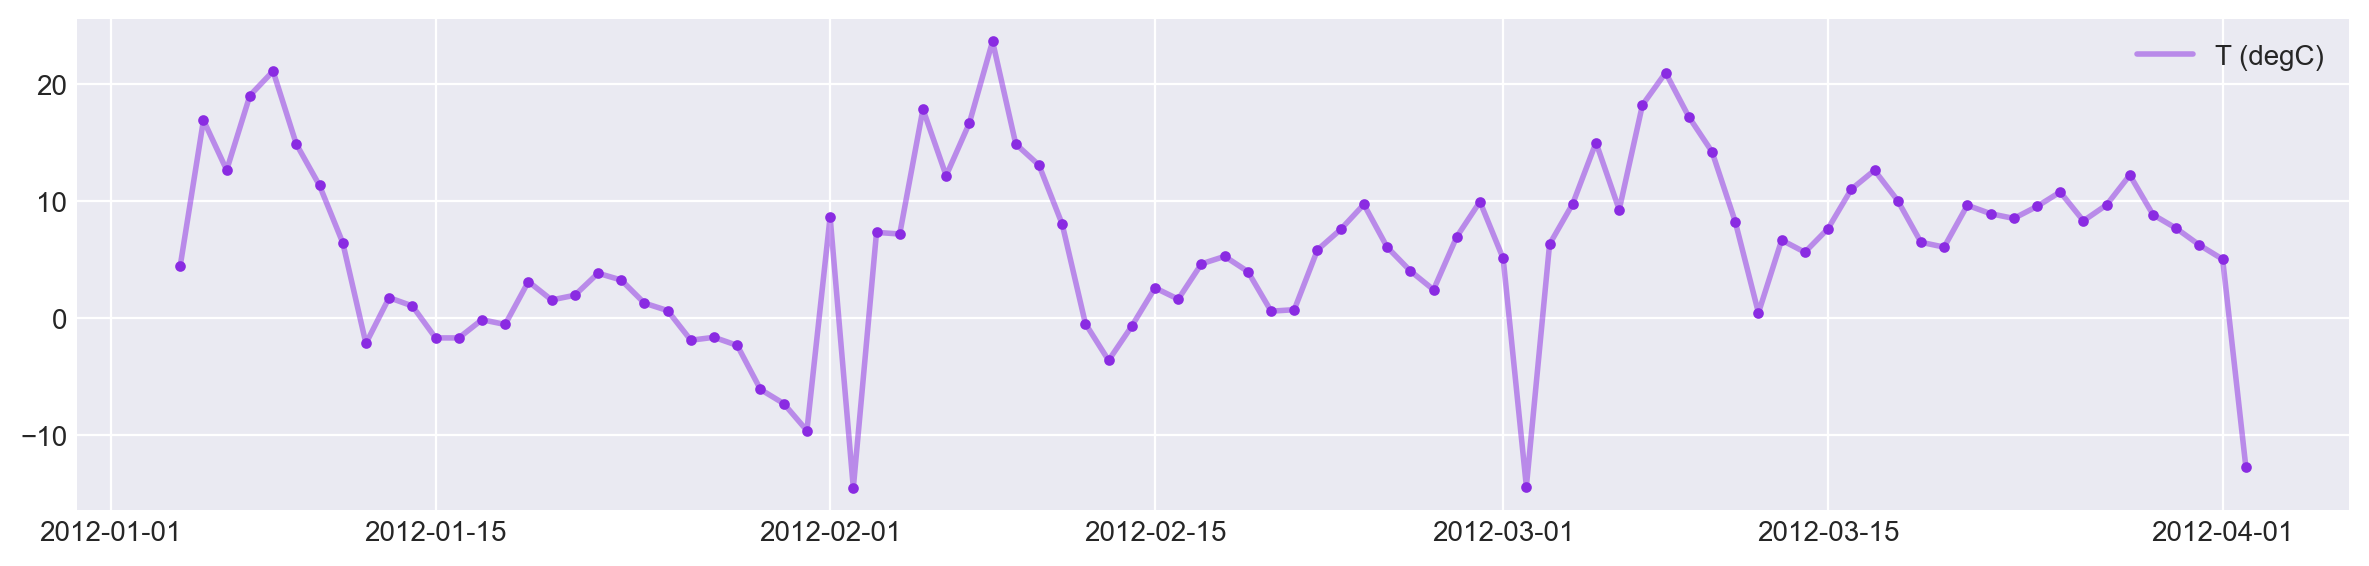

In [6]:
show_dataset(dataframe[:90], columns=["T (degC)"])

In [7]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "T (degC)"
TEST_SIZE = 30

In [8]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1825, 14)
dataframe shape after Feature Union (1822, 33)

Train Size after Test_Train Split: (1792, 33)
Test  Size after Test_Train Split: (30, 33) 

train_x shape after seperate_target (1792, 32)
train_y shape after seperate_target (1792, 1)
test_x  shape after seperate_target (30, 32)
test_y  shape after seperate_target (30, 1)


In [9]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.813 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.882 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.886 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.850 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.901 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.897 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.860 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.912 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.907 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.866 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.919 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

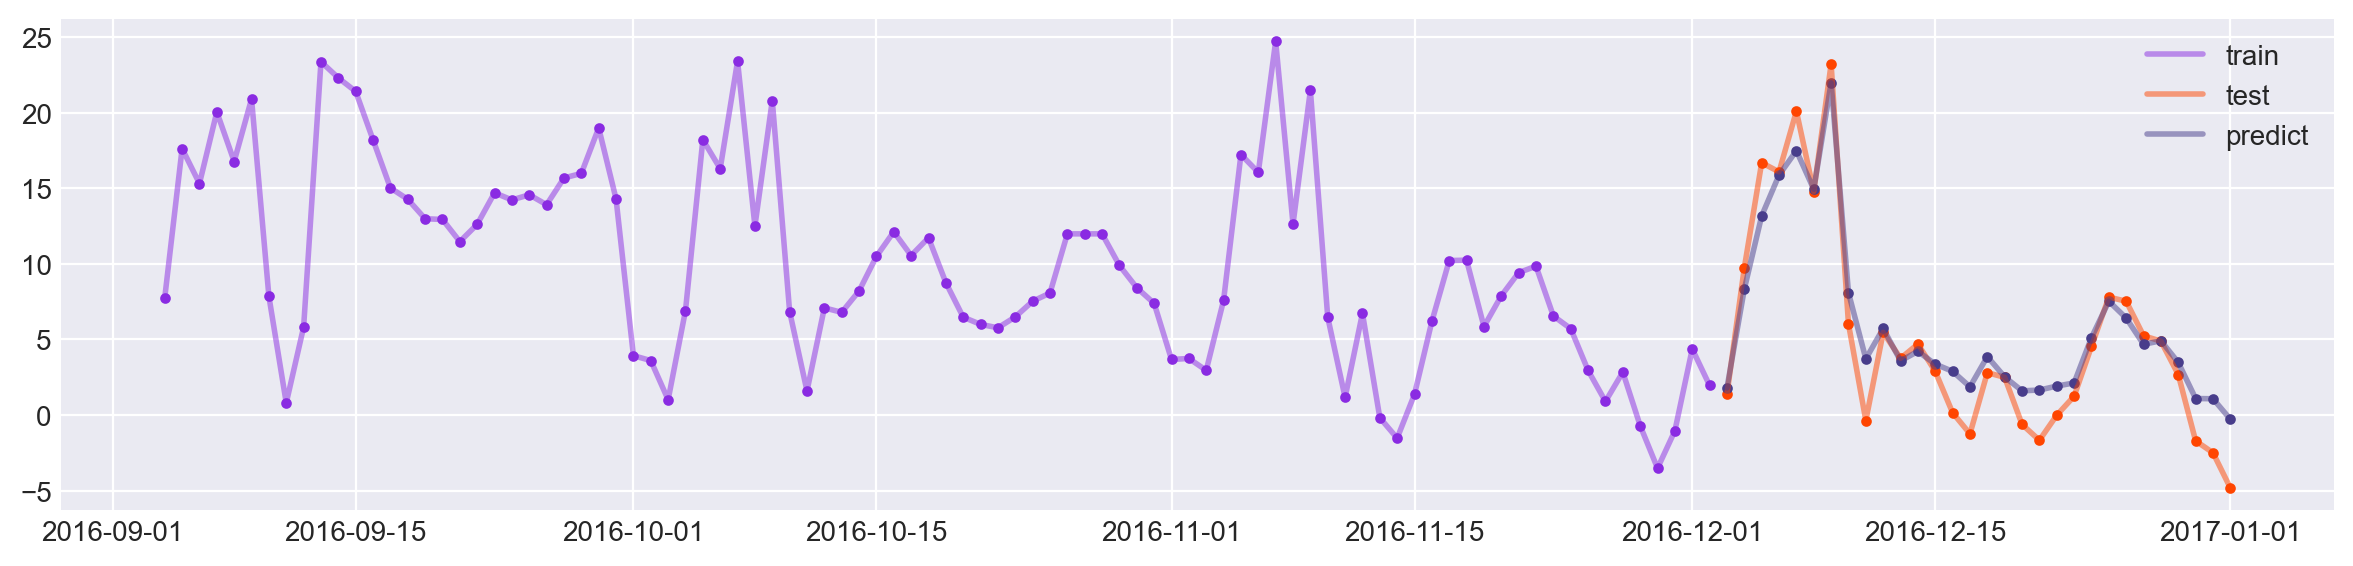

In [11]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [12]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  7  iterations


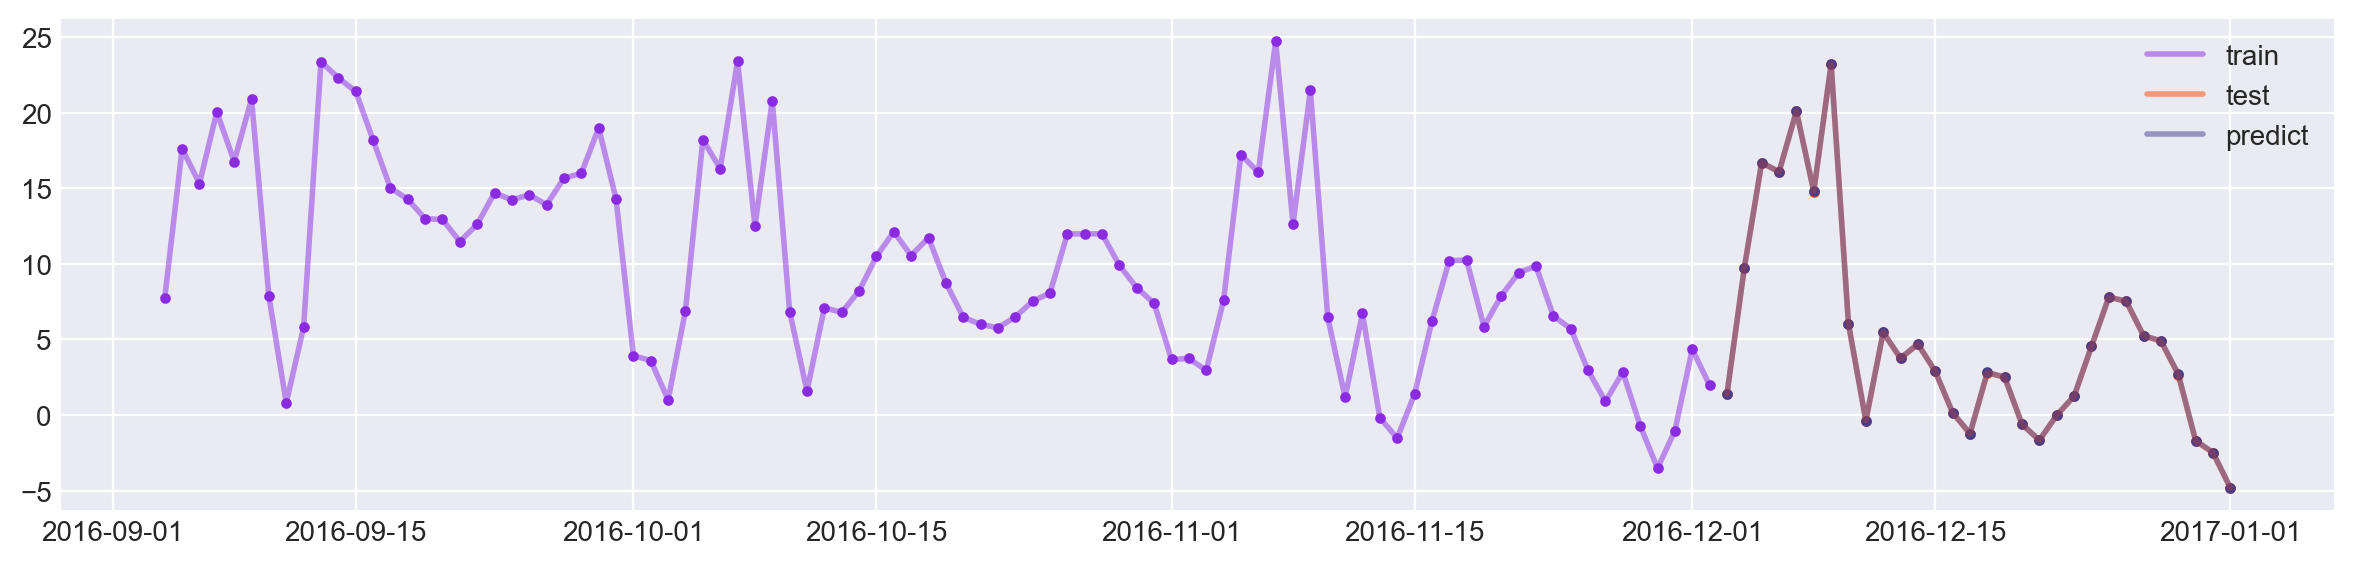

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [14]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

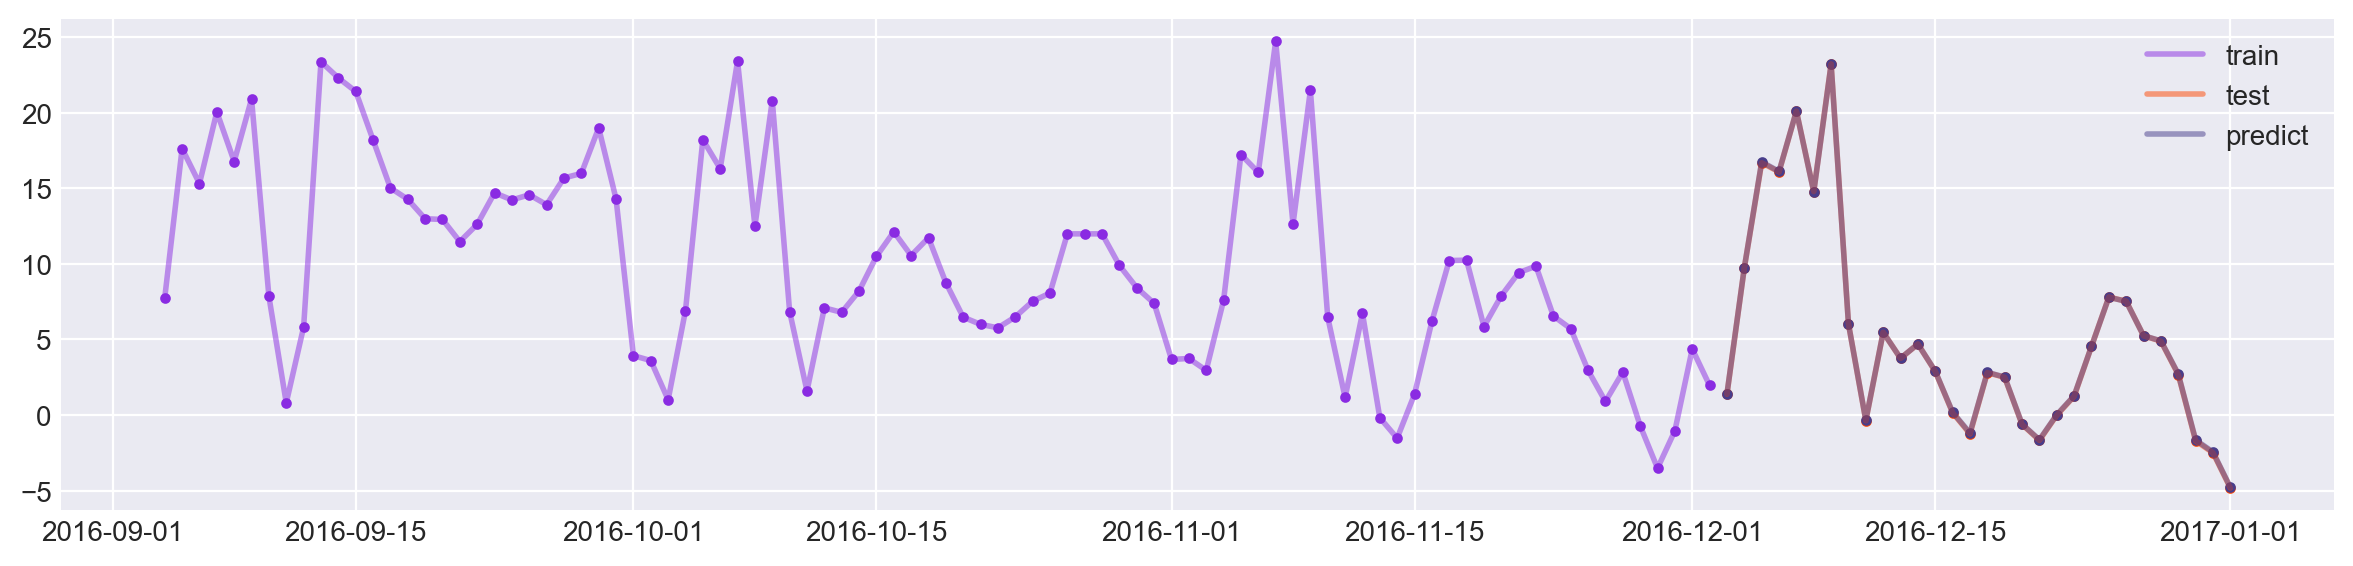

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.998 total time=   7.8s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.998 total time=  16.5s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.999 total time=  26.0s
0.9986178064616135 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}


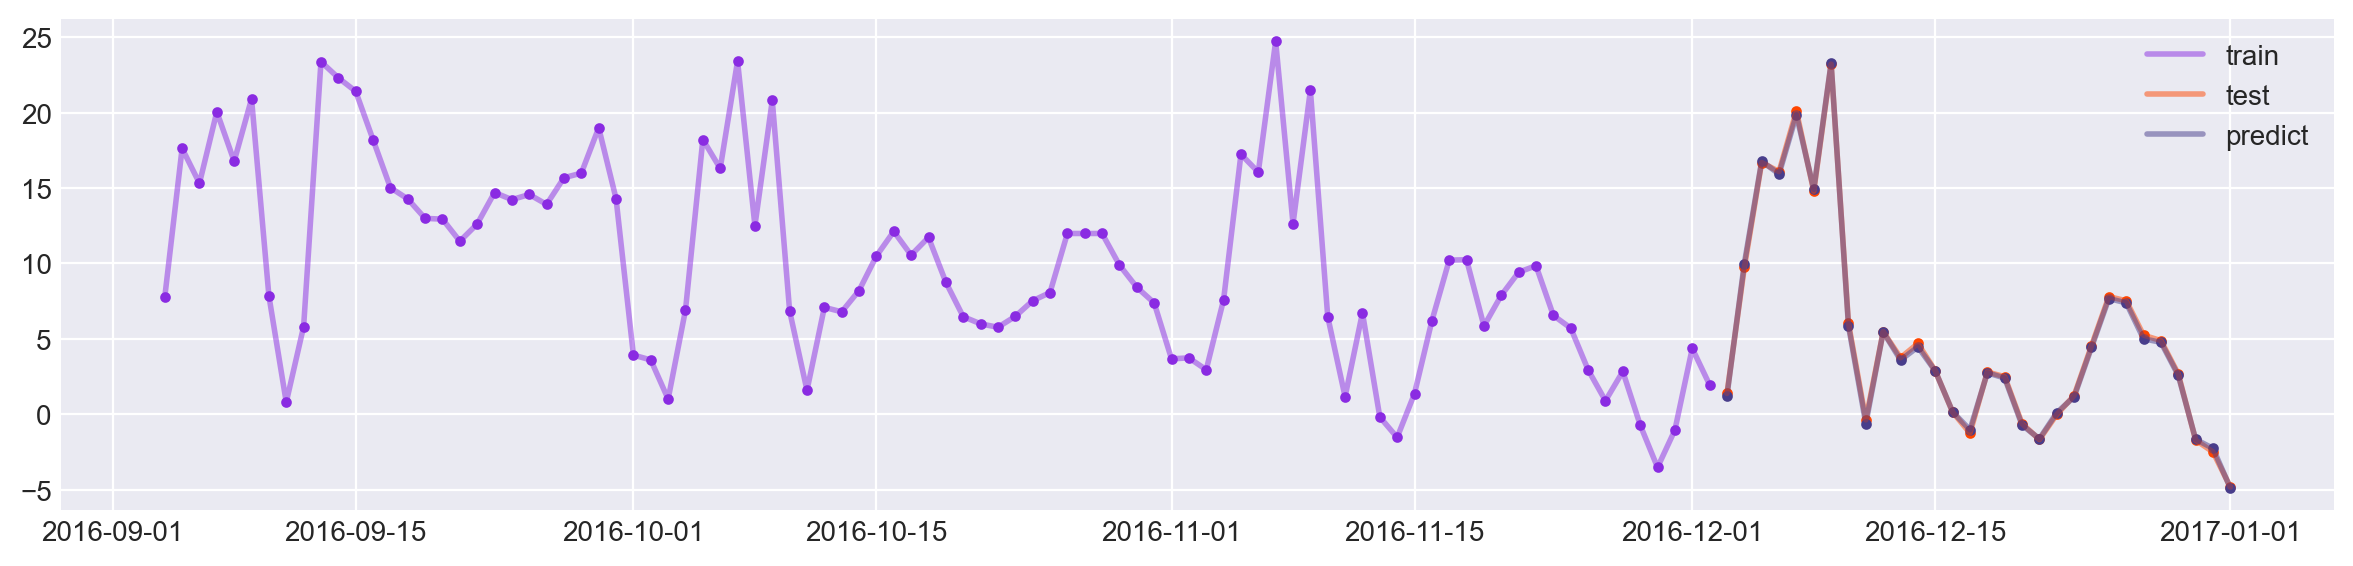

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:10.17375	validation_1-mae:5.63861
[1]	validation_0-mae:10.07279	validation_1-mae:5.58395
[2]	validation_0-mae:9.97283	validation_1-mae:5.53070
[3]	validation_0-mae:9.87387	validation_1-mae:5.47686
[4]	validation_0-mae:9.77597	validation_1-mae:5.42465
[5]	validation_0-mae:9.67906	validation_1-mae:5.37204
[6]	validation_0-mae:9.58311	validation_1-mae:5.31941
[7]	validation_0-mae:9.48812	validation_1-mae:5.26777
[8]	validation_0-mae:9.39409	validation_1-mae:5.21563
[9]	validation_0-mae:9.30096	validation_1-mae:5.16415
[10]	validation_0-mae:9.20874	validation_1-mae:5.11364
[11]	validation_0-mae:9.11756	validation_1-mae:5.06262
[12]	validation_0-mae:9.02727	validation_1-mae:5.01204
[13]	validation_0-mae:8.93781	validation_1-mae:4.96252
[14]	validation_0-mae:8.84931	validation_1-mae:4.91315
[15]	validation_0-mae:8.76170	validation_1-mae:4.86520
[16]	validation_0-mae:8.67479	validation_1-mae:4.81754
[17]	validation_0-mae:8.58889	validation_1-mae:4.76951
[18]	validation_0-

[148]	validation_0-mae:2.33426	validation_1-mae:1.31157
[149]	validation_0-mae:2.31120	validation_1-mae:1.29889
[150]	validation_0-mae:2.28838	validation_1-mae:1.28638
[151]	validation_0-mae:2.26578	validation_1-mae:1.27404
[152]	validation_0-mae:2.24341	validation_1-mae:1.26172
[153]	validation_0-mae:2.22126	validation_1-mae:1.24972
[154]	validation_0-mae:2.19931	validation_1-mae:1.23783
[155]	validation_0-mae:2.17762	validation_1-mae:1.22613
[156]	validation_0-mae:2.15612	validation_1-mae:1.21463
[157]	validation_0-mae:2.13484	validation_1-mae:1.20294
[158]	validation_0-mae:2.11377	validation_1-mae:1.19152
[159]	validation_0-mae:2.09290	validation_1-mae:1.17953
[160]	validation_0-mae:2.07224	validation_1-mae:1.16835
[161]	validation_0-mae:2.05181	validation_1-mae:1.15726
[162]	validation_0-mae:2.03157	validation_1-mae:1.14642
[163]	validation_0-mae:2.01154	validation_1-mae:1.13554
[164]	validation_0-mae:1.99170	validation_1-mae:1.12495
[165]	validation_0-mae:1.97204	validation_1-mae:

[295]	validation_0-mae:0.55013	validation_1-mae:0.38853
[296]	validation_0-mae:0.54485	validation_1-mae:0.38588
[297]	validation_0-mae:0.53963	validation_1-mae:0.38332
[298]	validation_0-mae:0.53444	validation_1-mae:0.38071
[299]	validation_0-mae:0.52934	validation_1-mae:0.37801
[300]	validation_0-mae:0.52427	validation_1-mae:0.37547
[301]	validation_0-mae:0.51926	validation_1-mae:0.37303
[302]	validation_0-mae:0.51429	validation_1-mae:0.37046
[303]	validation_0-mae:0.50938	validation_1-mae:0.36788
[304]	validation_0-mae:0.50451	validation_1-mae:0.36545
[305]	validation_0-mae:0.49969	validation_1-mae:0.36323
[306]	validation_0-mae:0.49493	validation_1-mae:0.36100
[307]	validation_0-mae:0.49020	validation_1-mae:0.35872
[308]	validation_0-mae:0.48553	validation_1-mae:0.35647
[309]	validation_0-mae:0.48091	validation_1-mae:0.35417
[310]	validation_0-mae:0.47633	validation_1-mae:0.35195
[311]	validation_0-mae:0.47179	validation_1-mae:0.34971
[312]	validation_0-mae:0.46730	validation_1-mae:

[441]	validation_0-mae:0.14953	validation_1-mae:0.19735
[442]	validation_0-mae:0.14841	validation_1-mae:0.19686
[443]	validation_0-mae:0.14729	validation_1-mae:0.19636
[444]	validation_0-mae:0.14619	validation_1-mae:0.19573
[445]	validation_0-mae:0.14512	validation_1-mae:0.19515
[446]	validation_0-mae:0.14404	validation_1-mae:0.19472
[447]	validation_0-mae:0.14297	validation_1-mae:0.19426
[448]	validation_0-mae:0.14191	validation_1-mae:0.19363
[449]	validation_0-mae:0.14088	validation_1-mae:0.19314
[450]	validation_0-mae:0.13986	validation_1-mae:0.19257
[451]	validation_0-mae:0.13883	validation_1-mae:0.19215
[452]	validation_0-mae:0.13783	validation_1-mae:0.19165
[453]	validation_0-mae:0.13683	validation_1-mae:0.19112
[454]	validation_0-mae:0.13584	validation_1-mae:0.19067
[455]	validation_0-mae:0.13486	validation_1-mae:0.19015
[456]	validation_0-mae:0.13391	validation_1-mae:0.18968
[457]	validation_0-mae:0.13295	validation_1-mae:0.18917
[458]	validation_0-mae:0.13200	validation_1-mae:

[588]	validation_0-mae:0.06996	validation_1-mae:0.16398
[589]	validation_0-mae:0.06975	validation_1-mae:0.16388
[590]	validation_0-mae:0.06954	validation_1-mae:0.16377
[591]	validation_0-mae:0.06934	validation_1-mae:0.16370
[592]	validation_0-mae:0.06914	validation_1-mae:0.16355
[593]	validation_0-mae:0.06895	validation_1-mae:0.16337
[594]	validation_0-mae:0.06875	validation_1-mae:0.16319
[595]	validation_0-mae:0.06856	validation_1-mae:0.16305
[596]	validation_0-mae:0.06836	validation_1-mae:0.16298
[597]	validation_0-mae:0.06818	validation_1-mae:0.16295
[598]	validation_0-mae:0.06799	validation_1-mae:0.16278
[599]	validation_0-mae:0.06781	validation_1-mae:0.16267
[600]	validation_0-mae:0.06763	validation_1-mae:0.16255
[601]	validation_0-mae:0.06745	validation_1-mae:0.16243
[602]	validation_0-mae:0.06727	validation_1-mae:0.16238
[603]	validation_0-mae:0.06709	validation_1-mae:0.16230
[604]	validation_0-mae:0.06691	validation_1-mae:0.16219
[605]	validation_0-mae:0.06674	validation_1-mae:

[735]	validation_0-mae:0.05314	validation_1-mae:0.15638
[736]	validation_0-mae:0.05306	validation_1-mae:0.15642
[737]	validation_0-mae:0.05300	validation_1-mae:0.15642
[738]	validation_0-mae:0.05293	validation_1-mae:0.15640
[739]	validation_0-mae:0.05286	validation_1-mae:0.15640
[740]	validation_0-mae:0.05279	validation_1-mae:0.15640
[741]	validation_0-mae:0.05273	validation_1-mae:0.15641
[742]	validation_0-mae:0.05268	validation_1-mae:0.15636
[743]	validation_0-mae:0.05262	validation_1-mae:0.15632
[744]	validation_0-mae:0.05255	validation_1-mae:0.15633
[745]	validation_0-mae:0.05249	validation_1-mae:0.15634
[746]	validation_0-mae:0.05242	validation_1-mae:0.15637
[747]	validation_0-mae:0.05237	validation_1-mae:0.15633
[748]	validation_0-mae:0.05231	validation_1-mae:0.15631
[749]	validation_0-mae:0.05225	validation_1-mae:0.15630
[750]	validation_0-mae:0.05219	validation_1-mae:0.15627
[751]	validation_0-mae:0.05212	validation_1-mae:0.15628
[752]	validation_0-mae:0.05207	validation_1-mae:

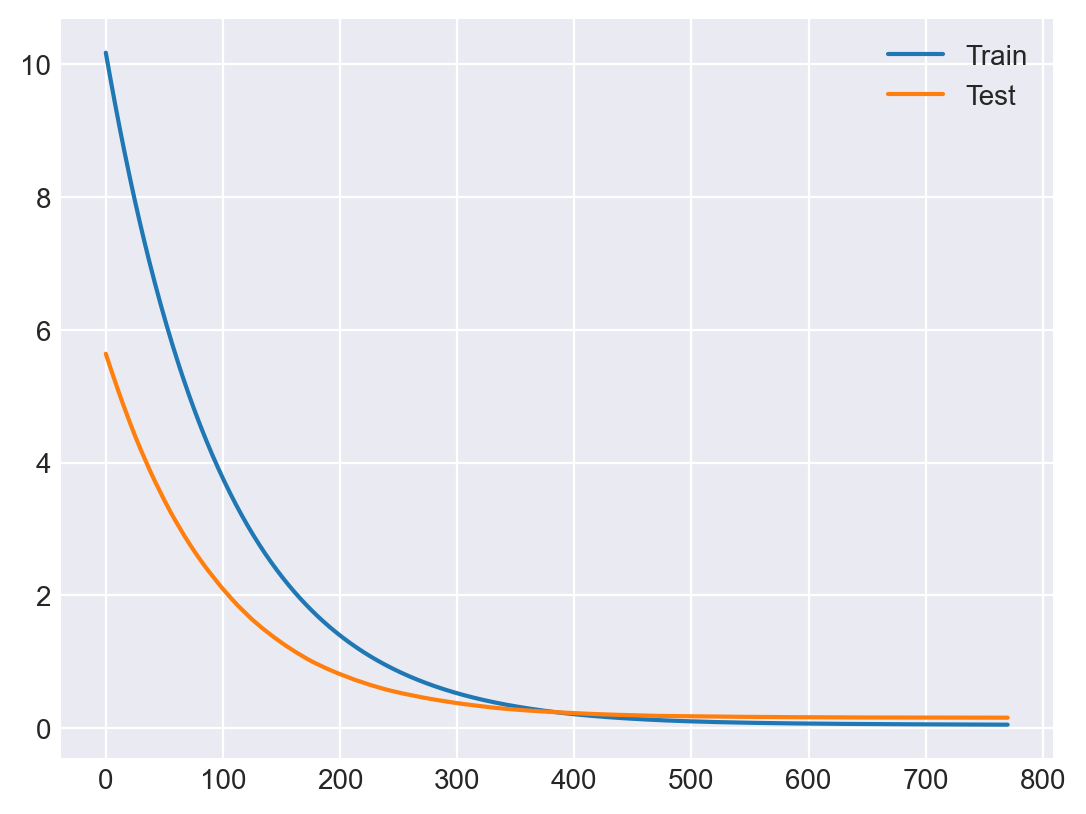

In [18]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

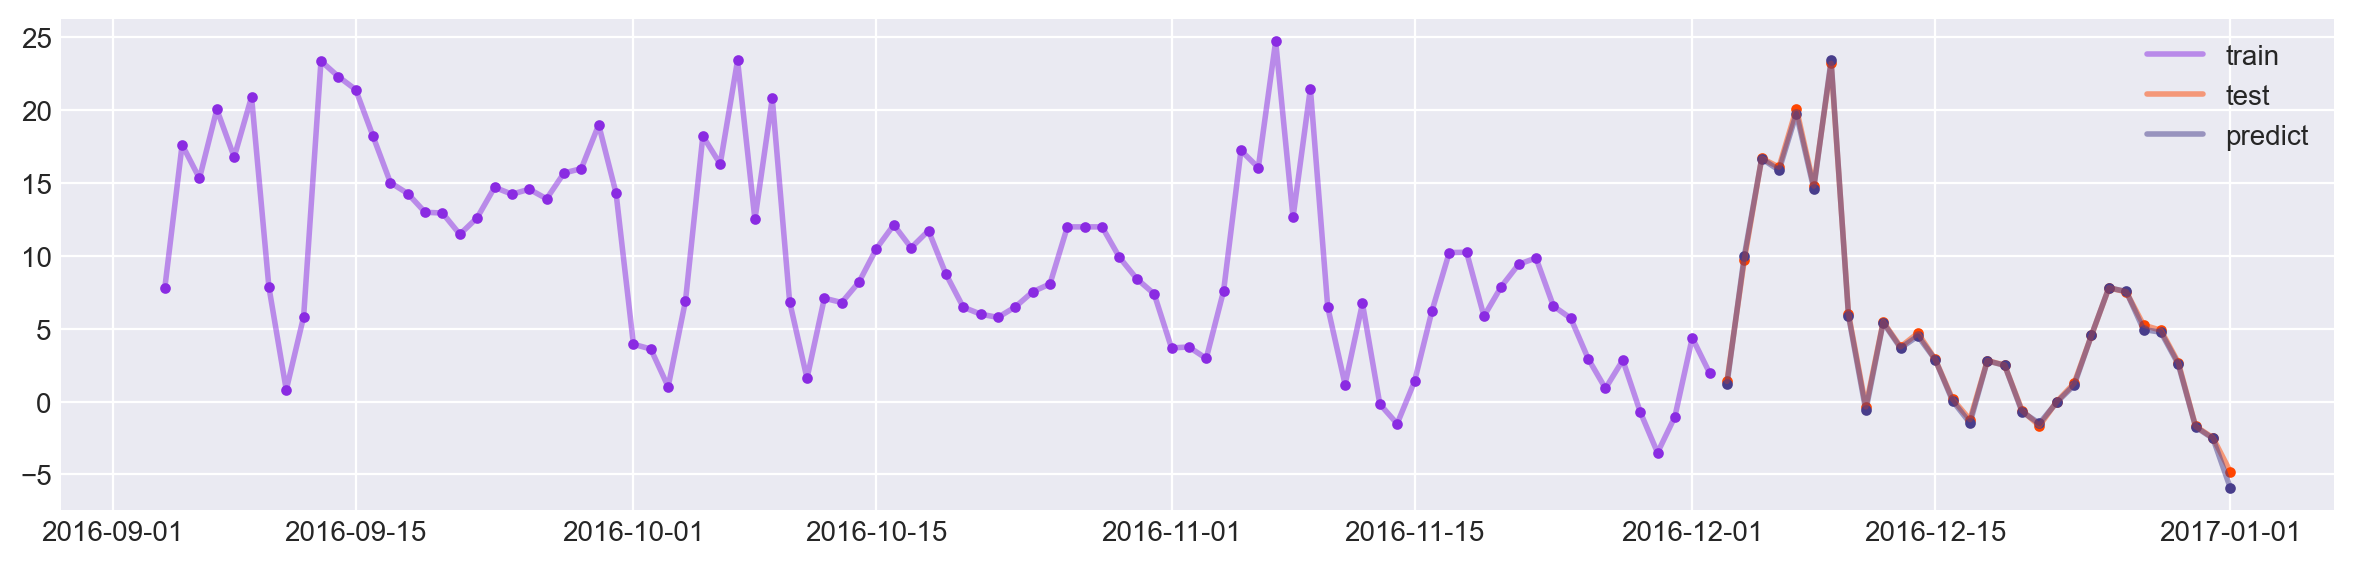

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [20]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 5.68202	training's l2: 46.6953	valid_1's l1: 6.94485	valid_1's l2: 57.9192
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 5.11517	training's l2: 37.8755	valid_1's l1: 6.2457	valid_1's l2: 46.8758
[3]	training's l1: 4.60507	training's l2: 30.7262	valid_1's l1: 5.62203	valid_1's l2: 38.0206
[4]	training's l1: 4.14584	training's l2: 24.9328	valid_1's l1: 5.05282	valid_1's l2: 30.7309
[5]	training's l1: 3.73243	training's l2: 20.2372	valid_1's l1: 4.54637	valid_1's l2: 24.8967
[6]	training's l1: 3.36073	training's l2: 16.4326	valid_1's l1: 4.08933	valid_1's l2: 20.1537
[7]	training's l1: 3.02607	training's l2: 13.3491	valid_1's l1: 3.67726	valid_1's l2: 16.3138
[8]	training's l1: 2.72501	training's l2: 10.8497	valid_1's l1: 3.29184	valid_1's l2: 13.0389
[9]	training's l1: 2.45437	training's l2: 8.82022	valid_1's l1: 2.94791	valid_1's l2: 10.4333
[10]	training's l1: 2.21017	training's l2: 7.17963	valid_1's l1: 2.6532	valid_1's l2: 8.4617

[96]	training's l1: 0.0747244	training's l2: 0.038427	valid_1's l1: 0.204705	valid_1's l2: 0.0813824
[97]	training's l1: 0.0743697	training's l2: 0.0377996	valid_1's l1: 0.201479	valid_1's l2: 0.078509
[98]	training's l1: 0.0739271	training's l2: 0.0375891	valid_1's l1: 0.199354	valid_1's l2: 0.0760519
[99]	training's l1: 0.0734575	training's l2: 0.0373117	valid_1's l1: 0.20181	valid_1's l2: 0.0788352
[100]	training's l1: 0.0730047	training's l2: 0.0371202	valid_1's l1: 0.19958	valid_1's l2: 0.0764035
Did not meet early stopping. Best iteration is:
[100]	training's l1: 0.0730047	training's l2: 0.0371202	valid_1's l1: 0.19958	valid_1's l2: 0.0764035


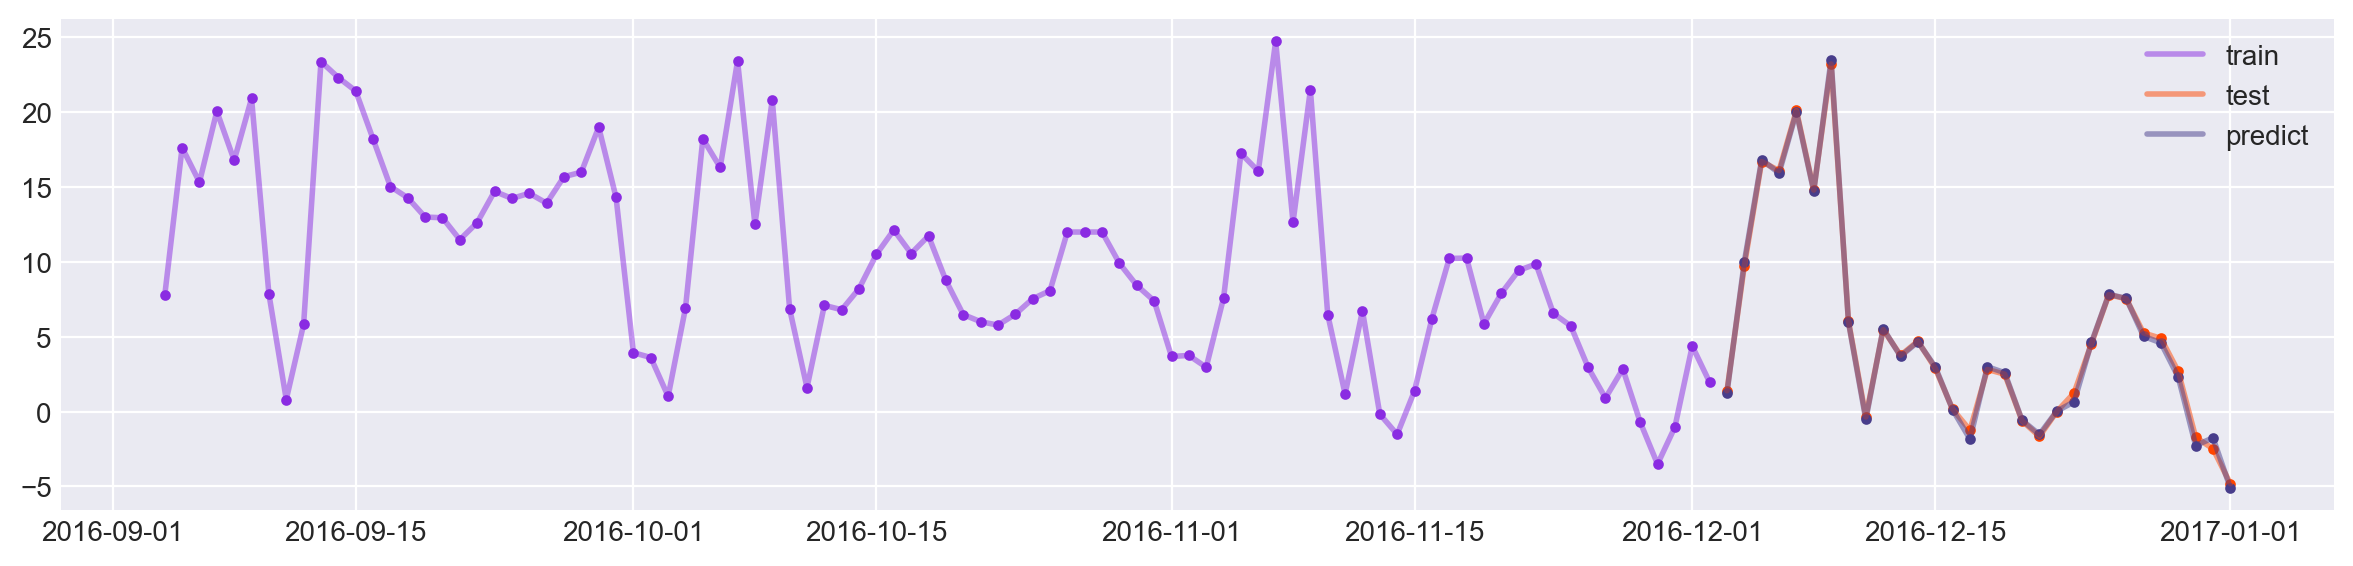

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [22]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 11.4528208	test: 11.4541040	best: 11.4541040 (0)	total: 150ms	remaining: 2m 29s
1:	learn: 10.4147316	test: 10.4046874	best: 10.4046874 (1)	total: 155ms	remaining: 1m 17s
2:	learn: 9.4614330	test: 9.4271259	best: 9.4271259 (2)	total: 162ms	remaining: 53.8s
3:	learn: 8.6101428	test: 8.5503827	best: 8.5503827 (3)	total: 168ms	remaining: 41.8s
4:	learn: 7.8269244	test: 7.7863045	best: 7.7863045 (4)	total: 174ms	remaining: 34.6s
5:	learn: 7.1443437	test: 7.0947045	best: 7.0947045 (5)	total: 180ms	remaining: 29.8s
6:	learn: 6.4976474	test: 6.4314981	best: 6.4314981 (6)	total: 184ms	remaining: 26.1s
7:	learn: 5.9092458	test: 5.8530491	best: 5.8530491 (7)	total: 188ms	remaining: 23.3s
8:	learn: 5.4138876	test: 5.3370280	best: 5.3370280 (8)	total: 199ms	remaining: 21.9s
9:	learn: 4.9530848	test: 4.8520707	best: 4.8520707 (9)	total: 214ms	remaining: 21.2s
10:	learn: 4.5329070	test: 4.4240920	best: 4.4240920 (10)	total: 227ms	remaining: 20.4s
11:	learn: 4.1495521	test: 4.0272013	best: 4

101:	learn: 0.3835267	test: 0.4061331	best: 0.4061331 (101)	total: 1.67s	remaining: 14.7s
102:	learn: 0.3825687	test: 0.4066178	best: 0.4061331 (101)	total: 1.7s	remaining: 14.8s
103:	learn: 0.3814610	test: 0.4057291	best: 0.4057291 (103)	total: 1.73s	remaining: 14.9s
104:	learn: 0.3809654	test: 0.4055569	best: 0.4055569 (104)	total: 1.74s	remaining: 14.9s
105:	learn: 0.3796097	test: 0.4057924	best: 0.4055569 (104)	total: 1.76s	remaining: 14.8s
106:	learn: 0.3784056	test: 0.4052536	best: 0.4052536 (106)	total: 1.77s	remaining: 14.8s
107:	learn: 0.3772569	test: 0.4049106	best: 0.4049106 (107)	total: 1.79s	remaining: 14.8s
108:	learn: 0.3753703	test: 0.4032472	best: 0.4032472 (108)	total: 1.8s	remaining: 14.7s
109:	learn: 0.3741946	test: 0.4030766	best: 0.4030766 (109)	total: 1.81s	remaining: 14.7s
110:	learn: 0.3735452	test: 0.4023336	best: 0.4023336 (110)	total: 1.87s	remaining: 15s
111:	learn: 0.3714780	test: 0.4008570	best: 0.4008570 (111)	total: 1.91s	remaining: 15.1s
112:	learn: 0.

201:	learn: 0.2706926	test: 0.3358910	best: 0.3358910 (201)	total: 3.2s	remaining: 12.6s
202:	learn: 0.2692339	test: 0.3346385	best: 0.3346385 (202)	total: 3.23s	remaining: 12.7s
203:	learn: 0.2678487	test: 0.3335233	best: 0.3335233 (203)	total: 3.25s	remaining: 12.7s
204:	learn: 0.2672486	test: 0.3328271	best: 0.3328271 (204)	total: 3.27s	remaining: 12.7s
205:	learn: 0.2665102	test: 0.3329116	best: 0.3328271 (204)	total: 3.28s	remaining: 12.7s
206:	learn: 0.2655452	test: 0.3325573	best: 0.3325573 (206)	total: 3.3s	remaining: 12.6s
207:	learn: 0.2648429	test: 0.3327994	best: 0.3325573 (206)	total: 3.31s	remaining: 12.6s
208:	learn: 0.2641722	test: 0.3325873	best: 0.3325573 (206)	total: 3.32s	remaining: 12.6s
209:	learn: 0.2637309	test: 0.3323621	best: 0.3323621 (209)	total: 3.35s	remaining: 12.6s
210:	learn: 0.2631123	test: 0.3321662	best: 0.3321662 (210)	total: 3.38s	remaining: 12.6s
211:	learn: 0.2628158	test: 0.3321883	best: 0.3321662 (210)	total: 3.42s	remaining: 12.7s
212:	learn: 

301:	learn: 0.2116476	test: 0.3074155	best: 0.3072958 (300)	total: 4.91s	remaining: 11.4s
302:	learn: 0.2115327	test: 0.3071557	best: 0.3071557 (302)	total: 4.94s	remaining: 11.4s
303:	learn: 0.2112969	test: 0.3070522	best: 0.3070522 (303)	total: 4.97s	remaining: 11.4s
304:	learn: 0.2109588	test: 0.3075077	best: 0.3070522 (303)	total: 4.98s	remaining: 11.4s
305:	learn: 0.2107126	test: 0.3075143	best: 0.3070522 (303)	total: 5s	remaining: 11.3s
306:	learn: 0.2102303	test: 0.3074696	best: 0.3070522 (303)	total: 5.01s	remaining: 11.3s
307:	learn: 0.2095868	test: 0.3065103	best: 0.3065103 (307)	total: 5.03s	remaining: 11.3s
308:	learn: 0.2091955	test: 0.3064909	best: 0.3064909 (308)	total: 5.04s	remaining: 11.3s
309:	learn: 0.2084316	test: 0.3060721	best: 0.3060721 (309)	total: 5.05s	remaining: 11.2s
310:	learn: 0.2080417	test: 0.3062169	best: 0.3060721 (309)	total: 5.08s	remaining: 11.3s
311:	learn: 0.2077501	test: 0.3062462	best: 0.3060721 (309)	total: 5.11s	remaining: 11.3s
312:	learn: 0

396:	learn: 0.1759497	test: 0.2947068	best: 0.2947068 (396)	total: 6.64s	remaining: 10.1s
397:	learn: 0.1755917	test: 0.2945847	best: 0.2945847 (397)	total: 6.68s	remaining: 10.1s
398:	learn: 0.1748551	test: 0.2940441	best: 0.2940441 (398)	total: 6.7s	remaining: 10.1s
399:	learn: 0.1745929	test: 0.2940763	best: 0.2940441 (398)	total: 6.72s	remaining: 10.1s
400:	learn: 0.1742876	test: 0.2937577	best: 0.2937577 (400)	total: 6.74s	remaining: 10.1s
401:	learn: 0.1739242	test: 0.2935947	best: 0.2935947 (401)	total: 6.75s	remaining: 10s
402:	learn: 0.1735727	test: 0.2931043	best: 0.2931043 (402)	total: 6.76s	remaining: 10s
403:	learn: 0.1732448	test: 0.2930240	best: 0.2930240 (403)	total: 6.77s	remaining: 9.99s
404:	learn: 0.1729282	test: 0.2931213	best: 0.2930240 (403)	total: 6.78s	remaining: 9.96s
405:	learn: 0.1727684	test: 0.2930206	best: 0.2930206 (405)	total: 6.8s	remaining: 9.96s
406:	learn: 0.1724395	test: 0.2932388	best: 0.2930206 (405)	total: 6.84s	remaining: 9.96s
407:	learn: 0.17

491:	learn: 0.1493985	test: 0.2888931	best: 0.2887405 (488)	total: 8.13s	remaining: 8.39s
492:	learn: 0.1491837	test: 0.2888925	best: 0.2887405 (488)	total: 8.14s	remaining: 8.37s
493:	learn: 0.1489055	test: 0.2889649	best: 0.2887405 (488)	total: 8.16s	remaining: 8.35s
494:	learn: 0.1486614	test: 0.2889260	best: 0.2887405 (488)	total: 8.19s	remaining: 8.36s
495:	learn: 0.1485171	test: 0.2887060	best: 0.2887060 (495)	total: 8.23s	remaining: 8.37s
496:	learn: 0.1482387	test: 0.2886584	best: 0.2886584 (496)	total: 8.26s	remaining: 8.36s
497:	learn: 0.1479002	test: 0.2888214	best: 0.2886584 (496)	total: 8.28s	remaining: 8.35s
498:	learn: 0.1476776	test: 0.2889076	best: 0.2886584 (496)	total: 8.3s	remaining: 8.34s
499:	learn: 0.1472367	test: 0.2887392	best: 0.2886584 (496)	total: 8.32s	remaining: 8.32s
500:	learn: 0.1468779	test: 0.2884923	best: 0.2884923 (500)	total: 8.36s	remaining: 8.32s
501:	learn: 0.1465088	test: 0.2884193	best: 0.2884193 (501)	total: 8.39s	remaining: 8.32s
502:	learn:

586:	learn: 0.1284035	test: 0.2842050	best: 0.2842050 (586)	total: 9.81s	remaining: 6.9s
587:	learn: 0.1280163	test: 0.2839504	best: 0.2839504 (587)	total: 9.82s	remaining: 6.88s
588:	learn: 0.1278017	test: 0.2838048	best: 0.2838048 (588)	total: 9.82s	remaining: 6.85s
589:	learn: 0.1275182	test: 0.2836110	best: 0.2836110 (589)	total: 9.82s	remaining: 6.83s
590:	learn: 0.1273843	test: 0.2835982	best: 0.2835982 (590)	total: 9.83s	remaining: 6.8s
591:	learn: 0.1271191	test: 0.2835628	best: 0.2835628 (591)	total: 9.86s	remaining: 6.79s
592:	learn: 0.1269181	test: 0.2834620	best: 0.2834620 (592)	total: 9.89s	remaining: 6.79s
593:	learn: 0.1267490	test: 0.2834773	best: 0.2834620 (592)	total: 9.91s	remaining: 6.78s
594:	learn: 0.1266255	test: 0.2833039	best: 0.2833039 (594)	total: 9.93s	remaining: 6.76s
595:	learn: 0.1264578	test: 0.2832525	best: 0.2832525 (595)	total: 9.95s	remaining: 6.74s
596:	learn: 0.1262556	test: 0.2832935	best: 0.2832525 (595)	total: 9.96s	remaining: 6.73s
597:	learn: 

680:	learn: 0.1118271	test: 0.2788685	best: 0.2788653 (677)	total: 11.5s	remaining: 5.4s
681:	learn: 0.1116782	test: 0.2789003	best: 0.2788653 (677)	total: 11.5s	remaining: 5.38s
682:	learn: 0.1115790	test: 0.2789794	best: 0.2788653 (677)	total: 11.5s	remaining: 5.36s
683:	learn: 0.1114434	test: 0.2789691	best: 0.2788653 (677)	total: 11.6s	remaining: 5.34s
684:	learn: 0.1112803	test: 0.2789983	best: 0.2788653 (677)	total: 11.6s	remaining: 5.33s
685:	learn: 0.1111299	test: 0.2789343	best: 0.2788653 (677)	total: 11.6s	remaining: 5.32s
686:	learn: 0.1110156	test: 0.2788769	best: 0.2788653 (677)	total: 11.6s	remaining: 5.3s
687:	learn: 0.1108966	test: 0.2787386	best: 0.2787386 (687)	total: 11.7s	remaining: 5.29s
688:	learn: 0.1108159	test: 0.2789954	best: 0.2787386 (687)	total: 11.7s	remaining: 5.27s
689:	learn: 0.1106837	test: 0.2789941	best: 0.2787386 (687)	total: 11.7s	remaining: 5.25s
690:	learn: 0.1105569	test: 0.2790495	best: 0.2787386 (687)	total: 11.7s	remaining: 5.23s
691:	learn: 

779:	learn: 0.0982320	test: 0.2758298	best: 0.2757875 (778)	total: 13.3s	remaining: 3.75s
780:	learn: 0.0981347	test: 0.2757960	best: 0.2757875 (778)	total: 13.3s	remaining: 3.73s
781:	learn: 0.0980074	test: 0.2757628	best: 0.2757628 (781)	total: 13.3s	remaining: 3.71s
782:	learn: 0.0978798	test: 0.2756293	best: 0.2756293 (782)	total: 13.3s	remaining: 3.69s
783:	learn: 0.0977905	test: 0.2756174	best: 0.2756174 (783)	total: 13.3s	remaining: 3.67s
784:	learn: 0.0977400	test: 0.2756037	best: 0.2756037 (784)	total: 13.3s	remaining: 3.65s
785:	learn: 0.0975674	test: 0.2755237	best: 0.2755237 (785)	total: 13.3s	remaining: 3.63s
786:	learn: 0.0975388	test: 0.2755043	best: 0.2755043 (786)	total: 13.3s	remaining: 3.61s
787:	learn: 0.0974407	test: 0.2754376	best: 0.2754376 (787)	total: 13.4s	remaining: 3.59s
788:	learn: 0.0973268	test: 0.2754142	best: 0.2754142 (788)	total: 13.4s	remaining: 3.58s
789:	learn: 0.0972173	test: 0.2753831	best: 0.2753831 (789)	total: 13.4s	remaining: 3.56s
790:	learn

879:	learn: 0.0867857	test: 0.2736839	best: 0.2736839 (879)	total: 15s	remaining: 2.05s
880:	learn: 0.0866897	test: 0.2736724	best: 0.2736724 (880)	total: 15.1s	remaining: 2.03s
881:	learn: 0.0865598	test: 0.2736829	best: 0.2736724 (880)	total: 15.1s	remaining: 2.02s
882:	learn: 0.0864715	test: 0.2736860	best: 0.2736724 (880)	total: 15.1s	remaining: 2s
883:	learn: 0.0863933	test: 0.2737002	best: 0.2736724 (880)	total: 15.1s	remaining: 1.98s
884:	learn: 0.0862954	test: 0.2736895	best: 0.2736724 (880)	total: 15.1s	remaining: 1.97s
885:	learn: 0.0861987	test: 0.2735562	best: 0.2735562 (885)	total: 15.1s	remaining: 1.95s
886:	learn: 0.0861691	test: 0.2735307	best: 0.2735307 (886)	total: 15.1s	remaining: 1.93s
887:	learn: 0.0860927	test: 0.2735147	best: 0.2735147 (887)	total: 15.2s	remaining: 1.91s
888:	learn: 0.0859138	test: 0.2734188	best: 0.2734188 (888)	total: 15.2s	remaining: 1.9s
889:	learn: 0.0858433	test: 0.2734753	best: 0.2734188 (888)	total: 15.2s	remaining: 1.88s
890:	learn: 0.08

985:	learn: 0.0762497	test: 0.2720324	best: 0.2719645 (980)	total: 16.8s	remaining: 238ms
986:	learn: 0.0761899	test: 0.2720479	best: 0.2719645 (980)	total: 16.8s	remaining: 221ms
987:	learn: 0.0760786	test: 0.2720380	best: 0.2719645 (980)	total: 16.8s	remaining: 204ms
988:	learn: 0.0760522	test: 0.2720200	best: 0.2719645 (980)	total: 16.8s	remaining: 187ms
989:	learn: 0.0759065	test: 0.2720728	best: 0.2719645 (980)	total: 16.8s	remaining: 170ms
990:	learn: 0.0757694	test: 0.2719452	best: 0.2719452 (990)	total: 16.9s	remaining: 153ms
991:	learn: 0.0757296	test: 0.2719355	best: 0.2719355 (991)	total: 16.9s	remaining: 136ms
992:	learn: 0.0756410	test: 0.2719337	best: 0.2719337 (992)	total: 16.9s	remaining: 119ms
993:	learn: 0.0755637	test: 0.2719889	best: 0.2719337 (992)	total: 16.9s	remaining: 102ms
994:	learn: 0.0754175	test: 0.2720459	best: 0.2719337 (992)	total: 16.9s	remaining: 85.1ms
995:	learn: 0.0753236	test: 0.2720071	best: 0.2719337 (992)	total: 17s	remaining: 68.2ms
996:	learn

80:	learn: 0.4341923	test: 0.4621617	best: 0.4621617 (80)	total: 1.52s	remaining: 17.2s
81:	learn: 0.4320985	test: 0.4616303	best: 0.4616303 (81)	total: 1.54s	remaining: 17.3s
82:	learn: 0.4307592	test: 0.4602530	best: 0.4602530 (82)	total: 1.56s	remaining: 17.2s
83:	learn: 0.4289904	test: 0.4604448	best: 0.4602530 (82)	total: 1.57s	remaining: 17.1s
84:	learn: 0.4274369	test: 0.4600171	best: 0.4600171 (84)	total: 1.58s	remaining: 17s
85:	learn: 0.4251419	test: 0.4580976	best: 0.4580976 (85)	total: 1.59s	remaining: 16.9s
86:	learn: 0.4231426	test: 0.4576074	best: 0.4576074 (86)	total: 1.61s	remaining: 17s
87:	learn: 0.4199364	test: 0.4564718	best: 0.4564718 (87)	total: 1.66s	remaining: 17.2s
88:	learn: 0.4188889	test: 0.4558039	best: 0.4558039 (88)	total: 1.69s	remaining: 17.3s
89:	learn: 0.4154026	test: 0.4524883	best: 0.4524883 (89)	total: 1.71s	remaining: 17.3s
90:	learn: 0.4139025	test: 0.4515990	best: 0.4515990 (90)	total: 1.72s	remaining: 17.2s
91:	learn: 0.4126274	test: 0.4513879

174:	learn: 0.3119602	test: 0.3779345	best: 0.3779345 (174)	total: 3.23s	remaining: 15.2s
175:	learn: 0.3111835	test: 0.3778984	best: 0.3778984 (175)	total: 3.24s	remaining: 15.2s
176:	learn: 0.3102618	test: 0.3774148	best: 0.3774148 (176)	total: 3.25s	remaining: 15.1s
177:	learn: 0.3094427	test: 0.3763888	best: 0.3763888 (177)	total: 3.26s	remaining: 15.1s
178:	learn: 0.3087948	test: 0.3765159	best: 0.3763888 (177)	total: 3.29s	remaining: 15.1s
179:	learn: 0.3079741	test: 0.3758111	best: 0.3758111 (179)	total: 3.32s	remaining: 15.1s
180:	learn: 0.3065146	test: 0.3747557	best: 0.3747557 (180)	total: 3.33s	remaining: 15.1s
181:	learn: 0.3060215	test: 0.3741443	best: 0.3741443 (181)	total: 3.35s	remaining: 15.1s
182:	learn: 0.3054513	test: 0.3730752	best: 0.3730752 (182)	total: 3.36s	remaining: 15s
183:	learn: 0.3042409	test: 0.3724226	best: 0.3724226 (183)	total: 3.37s	remaining: 15s
184:	learn: 0.3035115	test: 0.3709913	best: 0.3709913 (184)	total: 3.4s	remaining: 15s
185:	learn: 0.302

276:	learn: 0.2393503	test: 0.3308916	best: 0.3308916 (276)	total: 4.97s	remaining: 13s
277:	learn: 0.2388795	test: 0.3306853	best: 0.3306853 (277)	total: 4.97s	remaining: 12.9s
278:	learn: 0.2385069	test: 0.3302568	best: 0.3302568 (278)	total: 4.97s	remaining: 12.8s
279:	learn: 0.2379446	test: 0.3299372	best: 0.3299372 (279)	total: 4.98s	remaining: 12.8s
280:	learn: 0.2373895	test: 0.3296446	best: 0.3296446 (280)	total: 4.98s	remaining: 12.8s
281:	learn: 0.2370742	test: 0.3296417	best: 0.3296417 (281)	total: 5s	remaining: 12.7s
282:	learn: 0.2365846	test: 0.3294556	best: 0.3294556 (282)	total: 5.04s	remaining: 12.8s
283:	learn: 0.2361627	test: 0.3296176	best: 0.3294556 (282)	total: 5.07s	remaining: 12.8s
284:	learn: 0.2357805	test: 0.3288288	best: 0.3288288 (284)	total: 5.09s	remaining: 12.8s
285:	learn: 0.2354701	test: 0.3285027	best: 0.3285027 (285)	total: 5.1s	remaining: 12.7s
286:	learn: 0.2350765	test: 0.3280018	best: 0.3280018 (286)	total: 5.12s	remaining: 12.7s
287:	learn: 0.23

376:	learn: 0.1959965	test: 0.3109279	best: 0.3109279 (376)	total: 6.67s	remaining: 11s
377:	learn: 0.1954701	test: 0.3107355	best: 0.3107355 (377)	total: 6.7s	remaining: 11s
378:	learn: 0.1952688	test: 0.3107010	best: 0.3107010 (378)	total: 6.72s	remaining: 11s
379:	learn: 0.1947301	test: 0.3104460	best: 0.3104460 (379)	total: 6.73s	remaining: 11s
380:	learn: 0.1944250	test: 0.3104955	best: 0.3104460 (379)	total: 6.75s	remaining: 11s
381:	learn: 0.1940429	test: 0.3104986	best: 0.3104460 (379)	total: 6.76s	remaining: 10.9s
382:	learn: 0.1939645	test: 0.3104748	best: 0.3104460 (379)	total: 6.78s	remaining: 10.9s
383:	learn: 0.1935938	test: 0.3099629	best: 0.3099629 (383)	total: 6.79s	remaining: 10.9s
384:	learn: 0.1931815	test: 0.3096524	best: 0.3096524 (384)	total: 6.8s	remaining: 10.9s
385:	learn: 0.1925047	test: 0.3094499	best: 0.3094499 (385)	total: 6.83s	remaining: 10.9s
386:	learn: 0.1920391	test: 0.3088610	best: 0.3088610 (386)	total: 6.86s	remaining: 10.9s
387:	learn: 0.1915232	

468:	learn: 0.1676349	test: 0.2991722	best: 0.2991722 (468)	total: 8.19s	remaining: 9.27s
469:	learn: 0.1673434	test: 0.2991294	best: 0.2991294 (469)	total: 8.22s	remaining: 9.27s
470:	learn: 0.1672463	test: 0.2991936	best: 0.2991294 (469)	total: 8.28s	remaining: 9.3s
471:	learn: 0.1669247	test: 0.2990362	best: 0.2990362 (471)	total: 8.29s	remaining: 9.28s
472:	learn: 0.1667114	test: 0.2989018	best: 0.2989018 (472)	total: 8.31s	remaining: 9.26s
473:	learn: 0.1663014	test: 0.2986814	best: 0.2986814 (473)	total: 8.33s	remaining: 9.24s
474:	learn: 0.1660486	test: 0.2985987	best: 0.2985987 (474)	total: 8.34s	remaining: 9.22s
475:	learn: 0.1658463	test: 0.2985650	best: 0.2985650 (475)	total: 8.35s	remaining: 9.19s
476:	learn: 0.1655237	test: 0.2985403	best: 0.2985403 (476)	total: 8.36s	remaining: 9.16s
477:	learn: 0.1652093	test: 0.2984455	best: 0.2984455 (477)	total: 8.38s	remaining: 9.16s
478:	learn: 0.1649173	test: 0.2981662	best: 0.2981662 (478)	total: 8.41s	remaining: 9.15s
479:	learn:

568:	learn: 0.1446348	test: 0.2923341	best: 0.2923341 (568)	total: 9.88s	remaining: 7.48s
569:	learn: 0.1445654	test: 0.2923905	best: 0.2923341 (568)	total: 9.9s	remaining: 7.47s
570:	learn: 0.1442912	test: 0.2921513	best: 0.2921513 (570)	total: 9.92s	remaining: 7.45s
571:	learn: 0.1441134	test: 0.2920836	best: 0.2920836 (571)	total: 9.93s	remaining: 7.43s
572:	learn: 0.1439054	test: 0.2921310	best: 0.2920836 (571)	total: 9.93s	remaining: 7.4s
573:	learn: 0.1435700	test: 0.2919899	best: 0.2919899 (573)	total: 9.97s	remaining: 7.4s
574:	learn: 0.1434689	test: 0.2920100	best: 0.2919899 (573)	total: 10s	remaining: 7.39s
575:	learn: 0.1432792	test: 0.2919718	best: 0.2919718 (575)	total: 10s	remaining: 7.38s
576:	learn: 0.1430674	test: 0.2920201	best: 0.2919718 (575)	total: 10s	remaining: 7.36s
577:	learn: 0.1429161	test: 0.2920256	best: 0.2919718 (575)	total: 10.1s	remaining: 7.34s
578:	learn: 0.1426392	test: 0.2921905	best: 0.2919718 (575)	total: 10.1s	remaining: 7.32s
579:	learn: 0.14243

666:	learn: 0.1254784	test: 0.2858154	best: 0.2858154 (666)	total: 11.6s	remaining: 5.8s
667:	learn: 0.1253793	test: 0.2858348	best: 0.2858154 (666)	total: 11.7s	remaining: 5.79s
668:	learn: 0.1251654	test: 0.2858403	best: 0.2858154 (666)	total: 11.7s	remaining: 5.78s
669:	learn: 0.1249979	test: 0.2860466	best: 0.2858154 (666)	total: 11.7s	remaining: 5.77s
670:	learn: 0.1247833	test: 0.2859625	best: 0.2858154 (666)	total: 11.7s	remaining: 5.75s
671:	learn: 0.1247215	test: 0.2860132	best: 0.2858154 (666)	total: 11.7s	remaining: 5.73s
672:	learn: 0.1245149	test: 0.2859893	best: 0.2858154 (666)	total: 11.8s	remaining: 5.71s
673:	learn: 0.1244486	test: 0.2860545	best: 0.2858154 (666)	total: 11.8s	remaining: 5.69s
674:	learn: 0.1242306	test: 0.2860709	best: 0.2858154 (666)	total: 11.8s	remaining: 5.67s
675:	learn: 0.1240193	test: 0.2859651	best: 0.2858154 (666)	total: 11.8s	remaining: 5.64s
676:	learn: 0.1238569	test: 0.2859556	best: 0.2858154 (666)	total: 11.8s	remaining: 5.63s
677:	learn:

769:	learn: 0.1090578	test: 0.2824084	best: 0.2824084 (769)	total: 13.3s	remaining: 3.98s
770:	learn: 0.1088767	test: 0.2824426	best: 0.2824084 (769)	total: 13.4s	remaining: 3.97s
771:	learn: 0.1087727	test: 0.2824741	best: 0.2824084 (769)	total: 13.4s	remaining: 3.95s
772:	learn: 0.1086186	test: 0.2824986	best: 0.2824084 (769)	total: 13.4s	remaining: 3.94s
773:	learn: 0.1085118	test: 0.2823674	best: 0.2823674 (773)	total: 13.4s	remaining: 3.92s
774:	learn: 0.1083651	test: 0.2823993	best: 0.2823674 (773)	total: 13.4s	remaining: 3.9s
775:	learn: 0.1081748	test: 0.2822543	best: 0.2822543 (775)	total: 13.4s	remaining: 3.88s
776:	learn: 0.1079672	test: 0.2820686	best: 0.2820686 (776)	total: 13.5s	remaining: 3.86s
777:	learn: 0.1077952	test: 0.2820414	best: 0.2820414 (777)	total: 13.5s	remaining: 3.85s
778:	learn: 0.1076029	test: 0.2819521	best: 0.2819521 (778)	total: 13.5s	remaining: 3.83s
779:	learn: 0.1074406	test: 0.2819236	best: 0.2819236 (779)	total: 13.6s	remaining: 3.82s
780:	learn:

862:	learn: 0.0962141	test: 0.2786595	best: 0.2786595 (862)	total: 15.1s	remaining: 2.39s
863:	learn: 0.0961631	test: 0.2786995	best: 0.2786595 (862)	total: 15.1s	remaining: 2.38s
864:	learn: 0.0960080	test: 0.2786786	best: 0.2786595 (862)	total: 15.1s	remaining: 2.36s
865:	learn: 0.0958704	test: 0.2787772	best: 0.2786595 (862)	total: 15.1s	remaining: 2.34s
866:	learn: 0.0957888	test: 0.2787351	best: 0.2786595 (862)	total: 15.1s	remaining: 2.32s
867:	learn: 0.0957132	test: 0.2787674	best: 0.2786595 (862)	total: 15.2s	remaining: 2.31s
868:	learn: 0.0956372	test: 0.2786037	best: 0.2786037 (868)	total: 15.2s	remaining: 2.29s
869:	learn: 0.0955426	test: 0.2785994	best: 0.2785994 (869)	total: 15.2s	remaining: 2.27s
870:	learn: 0.0954451	test: 0.2786241	best: 0.2785994 (869)	total: 15.2s	remaining: 2.25s
871:	learn: 0.0953717	test: 0.2786775	best: 0.2785994 (869)	total: 15.2s	remaining: 2.23s
872:	learn: 0.0952969	test: 0.2787144	best: 0.2785994 (869)	total: 15.2s	remaining: 2.22s
873:	learn

962:	learn: 0.0853448	test: 0.2768258	best: 0.2768258 (962)	total: 17s	remaining: 654ms
963:	learn: 0.0852410	test: 0.2766908	best: 0.2766908 (963)	total: 17.1s	remaining: 637ms
964:	learn: 0.0851343	test: 0.2766896	best: 0.2766896 (964)	total: 17.1s	remaining: 620ms
965:	learn: 0.0850194	test: 0.2765492	best: 0.2765492 (965)	total: 17.1s	remaining: 603ms
966:	learn: 0.0849298	test: 0.2765893	best: 0.2765492 (965)	total: 17.1s	remaining: 585ms
967:	learn: 0.0848118	test: 0.2765287	best: 0.2765287 (967)	total: 17.2s	remaining: 567ms
968:	learn: 0.0847296	test: 0.2764848	best: 0.2764848 (968)	total: 17.2s	remaining: 549ms
969:	learn: 0.0846241	test: 0.2764819	best: 0.2764819 (969)	total: 17.2s	remaining: 532ms
970:	learn: 0.0845290	test: 0.2763777	best: 0.2763777 (970)	total: 17.2s	remaining: 515ms
971:	learn: 0.0844779	test: 0.2763386	best: 0.2763386 (971)	total: 17.3s	remaining: 497ms
972:	learn: 0.0843867	test: 0.2763895	best: 0.2763386 (971)	total: 17.3s	remaining: 480ms
973:	learn: 

60:	learn: 0.4791809	test: 1.3057828	best: 1.3057828 (60)	total: 970ms	remaining: 14.9s
61:	learn: 0.4751330	test: 1.2905136	best: 1.2905136 (61)	total: 975ms	remaining: 14.8s
62:	learn: 0.4718928	test: 1.2759244	best: 1.2759244 (62)	total: 979ms	remaining: 14.6s
63:	learn: 0.4689820	test: 1.2662604	best: 1.2662604 (63)	total: 982ms	remaining: 14.4s
64:	learn: 0.4651962	test: 1.2527875	best: 1.2527875 (64)	total: 991ms	remaining: 14.3s
65:	learn: 0.4619913	test: 1.2418974	best: 1.2418974 (65)	total: 1s	remaining: 14.2s
66:	learn: 0.4584606	test: 1.2385234	best: 1.2385234 (66)	total: 1.02s	remaining: 14.3s
67:	learn: 0.4540408	test: 1.2365798	best: 1.2365798 (67)	total: 1.05s	remaining: 14.5s
68:	learn: 0.4503975	test: 1.2341621	best: 1.2341621 (68)	total: 1.08s	remaining: 14.6s
69:	learn: 0.4472296	test: 1.2285832	best: 1.2285832 (69)	total: 1.1s	remaining: 14.6s
70:	learn: 0.4436471	test: 1.2204815	best: 1.2204815 (70)	total: 1.11s	remaining: 14.5s
71:	learn: 0.4375467	test: 1.2178141

160:	learn: 0.2850995	test: 1.0929779	best: 1.0920509 (157)	total: 2.7s	remaining: 14.1s
161:	learn: 0.2842155	test: 1.0932601	best: 1.0920509 (157)	total: 2.74s	remaining: 14.2s
162:	learn: 0.2827515	test: 1.0928679	best: 1.0920509 (157)	total: 2.77s	remaining: 14.2s
163:	learn: 0.2812978	test: 1.0917946	best: 1.0917946 (163)	total: 2.8s	remaining: 14.3s
164:	learn: 0.2805943	test: 1.0903234	best: 1.0903234 (164)	total: 2.81s	remaining: 14.2s
165:	learn: 0.2797930	test: 1.0897745	best: 1.0897745 (165)	total: 2.83s	remaining: 14.2s
166:	learn: 0.2790823	test: 1.0897459	best: 1.0897459 (166)	total: 2.85s	remaining: 14.2s
167:	learn: 0.2781850	test: 1.0888254	best: 1.0888254 (167)	total: 2.86s	remaining: 14.2s
168:	learn: 0.2775416	test: 1.0892324	best: 1.0888254 (167)	total: 2.87s	remaining: 14.1s
169:	learn: 0.2753829	test: 1.0885689	best: 1.0885689 (169)	total: 2.88s	remaining: 14.1s
170:	learn: 0.2735853	test: 1.0885844	best: 1.0885689 (169)	total: 2.89s	remaining: 14s
171:	learn: 0.

261:	learn: 0.2147732	test: 1.0734541	best: 1.0734541 (261)	total: 4.43s	remaining: 12.5s
262:	learn: 0.2139507	test: 1.0734991	best: 1.0734541 (261)	total: 4.44s	remaining: 12.4s
263:	learn: 0.2138881	test: 1.0727116	best: 1.0727116 (263)	total: 4.44s	remaining: 12.4s
264:	learn: 0.2135196	test: 1.0724542	best: 1.0724542 (264)	total: 4.44s	remaining: 12.3s
265:	learn: 0.2129008	test: 1.0723616	best: 1.0723616 (265)	total: 4.45s	remaining: 12.3s
266:	learn: 0.2118979	test: 1.0707545	best: 1.0707545 (266)	total: 4.45s	remaining: 12.2s
267:	learn: 0.2112992	test: 1.0709087	best: 1.0707545 (266)	total: 4.46s	remaining: 12.2s
268:	learn: 0.2106453	test: 1.0707057	best: 1.0707057 (268)	total: 4.48s	remaining: 12.2s
269:	learn: 0.2101815	test: 1.0705812	best: 1.0705812 (269)	total: 4.51s	remaining: 12.2s
270:	learn: 0.2093293	test: 1.0703938	best: 1.0703938 (270)	total: 4.54s	remaining: 12.2s
271:	learn: 0.2087181	test: 1.0700431	best: 1.0700431 (271)	total: 4.56s	remaining: 12.2s
272:	learn

364:	learn: 0.1672688	test: 1.0591235	best: 1.0591235 (364)	total: 6.19s	remaining: 10.8s
365:	learn: 0.1669718	test: 1.0591494	best: 1.0591235 (364)	total: 6.19s	remaining: 10.7s
366:	learn: 0.1665822	test: 1.0591586	best: 1.0591235 (364)	total: 6.19s	remaining: 10.7s
367:	learn: 0.1661430	test: 1.0591698	best: 1.0591235 (364)	total: 6.2s	remaining: 10.6s
368:	learn: 0.1657831	test: 1.0590098	best: 1.0590098 (368)	total: 6.2s	remaining: 10.6s
369:	learn: 0.1654128	test: 1.0586224	best: 1.0586224 (369)	total: 6.2s	remaining: 10.6s
370:	learn: 0.1651381	test: 1.0584308	best: 1.0584308 (370)	total: 6.22s	remaining: 10.5s
371:	learn: 0.1647682	test: 1.0584372	best: 1.0584308 (370)	total: 6.25s	remaining: 10.6s
372:	learn: 0.1643676	test: 1.0584537	best: 1.0584308 (370)	total: 6.29s	remaining: 10.6s
373:	learn: 0.1639555	test: 1.0586399	best: 1.0584308 (370)	total: 6.3s	remaining: 10.6s
374:	learn: 0.1635812	test: 1.0584462	best: 1.0584308 (370)	total: 6.32s	remaining: 10.5s
375:	learn: 0.

465:	learn: 0.1365198	test: 1.0582473	best: 1.0574242 (417)	total: 7.93s	remaining: 9.08s
466:	learn: 0.1363271	test: 1.0583325	best: 1.0574242 (417)	total: 7.94s	remaining: 9.06s
467:	learn: 0.1361258	test: 1.0586968	best: 1.0574242 (417)	total: 7.95s	remaining: 9.03s
468:	learn: 0.1357398	test: 1.0580760	best: 1.0574242 (417)	total: 7.96s	remaining: 9.01s
469:	learn: 0.1353907	test: 1.0579646	best: 1.0574242 (417)	total: 7.98s	remaining: 9s
470:	learn: 0.1350642	test: 1.0579434	best: 1.0574242 (417)	total: 8.01s	remaining: 9s
471:	learn: 0.1347319	test: 1.0578067	best: 1.0574242 (417)	total: 8.04s	remaining: 9s
472:	learn: 0.1344434	test: 1.0576848	best: 1.0574242 (417)	total: 8.06s	remaining: 8.98s
473:	learn: 0.1340954	test: 1.0575452	best: 1.0574242 (417)	total: 8.08s	remaining: 8.96s
474:	learn: 0.1338584	test: 1.0574669	best: 1.0574242 (417)	total: 8.09s	remaining: 8.94s
475:	learn: 0.1335556	test: 1.0574675	best: 1.0574242 (417)	total: 8.11s	remaining: 8.93s
476:	learn: 0.13326

558:	learn: 0.1142440	test: 1.0554281	best: 1.0551133 (554)	total: 9.68s	remaining: 7.64s
559:	learn: 0.1140555	test: 1.0553690	best: 1.0551133 (554)	total: 9.72s	remaining: 7.63s
560:	learn: 0.1138968	test: 1.0551183	best: 1.0551133 (554)	total: 9.73s	remaining: 7.61s
561:	learn: 0.1137385	test: 1.0552192	best: 1.0551133 (554)	total: 9.75s	remaining: 7.59s
562:	learn: 0.1133926	test: 1.0551909	best: 1.0551133 (554)	total: 9.76s	remaining: 7.58s
563:	learn: 0.1131650	test: 1.0553657	best: 1.0551133 (554)	total: 9.78s	remaining: 7.56s
564:	learn: 0.1128795	test: 1.0553293	best: 1.0551133 (554)	total: 9.79s	remaining: 7.54s
565:	learn: 0.1127435	test: 1.0553325	best: 1.0551133 (554)	total: 9.8s	remaining: 7.51s
566:	learn: 0.1124910	test: 1.0553060	best: 1.0551133 (554)	total: 9.81s	remaining: 7.49s
567:	learn: 0.1122790	test: 1.0551424	best: 1.0551133 (554)	total: 9.83s	remaining: 7.47s
568:	learn: 0.1121310	test: 1.0551324	best: 1.0551133 (554)	total: 9.86s	remaining: 7.47s
569:	learn:

662:	learn: 0.0947150	test: 1.0551914	best: 1.0550269 (657)	total: 11.4s	remaining: 5.8s
663:	learn: 0.0945348	test: 1.0551511	best: 1.0550269 (657)	total: 11.4s	remaining: 5.79s
664:	learn: 0.0944342	test: 1.0553874	best: 1.0550269 (657)	total: 11.5s	remaining: 5.78s
665:	learn: 0.0942553	test: 1.0554264	best: 1.0550269 (657)	total: 11.5s	remaining: 5.76s
666:	learn: 0.0940477	test: 1.0555104	best: 1.0550269 (657)	total: 11.5s	remaining: 5.74s
667:	learn: 0.0938840	test: 1.0555773	best: 1.0550269 (657)	total: 11.5s	remaining: 5.72s
668:	learn: 0.0937394	test: 1.0555296	best: 1.0550269 (657)	total: 11.5s	remaining: 5.71s
669:	learn: 0.0936837	test: 1.0555355	best: 1.0550269 (657)	total: 11.5s	remaining: 5.68s
670:	learn: 0.0934630	test: 1.0555066	best: 1.0550269 (657)	total: 11.6s	remaining: 5.66s
671:	learn: 0.0933242	test: 1.0555437	best: 1.0550269 (657)	total: 11.6s	remaining: 5.65s
672:	learn: 0.0931618	test: 1.0556158	best: 1.0550269 (657)	total: 11.6s	remaining: 5.64s
673:	learn:

767:	learn: 0.0807636	test: 1.0549377	best: 1.0549377 (767)	total: 13.1s	remaining: 3.96s
768:	learn: 0.0806090	test: 1.0549518	best: 1.0549377 (767)	total: 13.1s	remaining: 3.94s
769:	learn: 0.0804636	test: 1.0549459	best: 1.0549377 (767)	total: 13.1s	remaining: 3.92s
770:	learn: 0.0803905	test: 1.0549534	best: 1.0549377 (767)	total: 13.1s	remaining: 3.9s
771:	learn: 0.0802934	test: 1.0549685	best: 1.0549377 (767)	total: 13.1s	remaining: 3.88s
772:	learn: 0.0801771	test: 1.0549354	best: 1.0549354 (772)	total: 13.1s	remaining: 3.85s
773:	learn: 0.0800301	test: 1.0548941	best: 1.0548941 (773)	total: 13.1s	remaining: 3.83s
774:	learn: 0.0798875	test: 1.0546791	best: 1.0546791 (774)	total: 13.1s	remaining: 3.81s
775:	learn: 0.0798154	test: 1.0546807	best: 1.0546791 (774)	total: 13.1s	remaining: 3.79s
776:	learn: 0.0797198	test: 1.0545730	best: 1.0545730 (776)	total: 13.2s	remaining: 3.78s
777:	learn: 0.0796075	test: 1.0546001	best: 1.0545730 (776)	total: 13.2s	remaining: 3.77s
778:	learn:

867:	learn: 0.0696538	test: 1.0547772	best: 1.0545730 (776)	total: 14.9s	remaining: 2.26s
868:	learn: 0.0695354	test: 1.0548547	best: 1.0545730 (776)	total: 14.9s	remaining: 2.25s
869:	learn: 0.0694072	test: 1.0547906	best: 1.0545730 (776)	total: 14.9s	remaining: 2.23s
870:	learn: 0.0692259	test: 1.0547686	best: 1.0545730 (776)	total: 14.9s	remaining: 2.21s
871:	learn: 0.0691328	test: 1.0548453	best: 1.0545730 (776)	total: 14.9s	remaining: 2.19s
872:	learn: 0.0690432	test: 1.0548340	best: 1.0545730 (776)	total: 15s	remaining: 2.18s
873:	learn: 0.0689747	test: 1.0548524	best: 1.0545730 (776)	total: 15s	remaining: 2.16s
874:	learn: 0.0688869	test: 1.0548200	best: 1.0545730 (776)	total: 15s	remaining: 2.14s
875:	learn: 0.0687756	test: 1.0548084	best: 1.0545730 (776)	total: 15s	remaining: 2.12s
876:	learn: 0.0686855	test: 1.0548644	best: 1.0545730 (776)	total: 15s	remaining: 2.11s
877:	learn: 0.0685677	test: 1.0548533	best: 1.0545730 (776)	total: 15.1s	remaining: 2.09s
878:	learn: 0.068450

963:	learn: 0.0602517	test: 1.0551842	best: 1.0545569 (894)	total: 16.4s	remaining: 613ms
964:	learn: 0.0601944	test: 1.0551826	best: 1.0545569 (894)	total: 16.4s	remaining: 597ms
965:	learn: 0.0600788	test: 1.0551639	best: 1.0545569 (894)	total: 16.5s	remaining: 580ms
966:	learn: 0.0599920	test: 1.0551493	best: 1.0545569 (894)	total: 16.5s	remaining: 563ms
967:	learn: 0.0599352	test: 1.0551725	best: 1.0545569 (894)	total: 16.5s	remaining: 546ms
968:	learn: 0.0598708	test: 1.0551784	best: 1.0545569 (894)	total: 16.5s	remaining: 529ms
969:	learn: 0.0598338	test: 1.0549791	best: 1.0545569 (894)	total: 16.5s	remaining: 512ms
970:	learn: 0.0597687	test: 1.0549791	best: 1.0545569 (894)	total: 16.6s	remaining: 494ms
971:	learn: 0.0596623	test: 1.0549746	best: 1.0545569 (894)	total: 16.6s	remaining: 477ms
972:	learn: 0.0595987	test: 1.0549549	best: 1.0545569 (894)	total: 16.6s	remaining: 460ms
973:	learn: 0.0595719	test: 1.0549756	best: 1.0545569 (894)	total: 16.6s	remaining: 444ms
974:	learn

66:	learn: 0.4591108	test: 0.5267573	best: 0.5267573 (66)	total: 1.07s	remaining: 15s
67:	learn: 0.4550441	test: 0.5221649	best: 0.5221649 (67)	total: 1.08s	remaining: 14.8s
68:	learn: 0.4518115	test: 0.5198923	best: 0.5198923 (68)	total: 1.08s	remaining: 14.6s
69:	learn: 0.4477500	test: 0.5163683	best: 0.5163683 (69)	total: 1.08s	remaining: 14.4s
70:	learn: 0.4444551	test: 0.5141939	best: 0.5141939 (70)	total: 1.08s	remaining: 14.2s
71:	learn: 0.4388552	test: 0.5081847	best: 0.5081847 (71)	total: 1.09s	remaining: 14s
72:	learn: 0.4340734	test: 0.5028744	best: 0.5028744 (72)	total: 1.09s	remaining: 13.9s
73:	learn: 0.4314423	test: 0.5013992	best: 0.5013992 (73)	total: 1.1s	remaining: 13.7s
74:	learn: 0.4278937	test: 0.4993317	best: 0.4993317 (74)	total: 1.11s	remaining: 13.7s
75:	learn: 0.4253139	test: 0.4966923	best: 0.4966923 (75)	total: 1.14s	remaining: 13.9s
76:	learn: 0.4231828	test: 0.4964090	best: 0.4964090 (76)	total: 1.17s	remaining: 14s
77:	learn: 0.4204205	test: 0.4954092	be

168:	learn: 0.2831860	test: 0.3992249	best: 0.3992249 (168)	total: 2.82s	remaining: 13.8s
169:	learn: 0.2821904	test: 0.3984303	best: 0.3984303 (169)	total: 2.84s	remaining: 13.9s
170:	learn: 0.2813755	test: 0.3982313	best: 0.3982313 (170)	total: 2.85s	remaining: 13.8s
171:	learn: 0.2806343	test: 0.3979463	best: 0.3979463 (171)	total: 2.88s	remaining: 13.8s
172:	learn: 0.2797150	test: 0.3977780	best: 0.3977780 (172)	total: 2.91s	remaining: 13.9s
173:	learn: 0.2793129	test: 0.3978770	best: 0.3977780 (172)	total: 2.94s	remaining: 13.9s
174:	learn: 0.2785061	test: 0.3973073	best: 0.3973073 (174)	total: 2.95s	remaining: 13.9s
175:	learn: 0.2777870	test: 0.3971117	best: 0.3971117 (175)	total: 2.97s	remaining: 13.9s
176:	learn: 0.2770599	test: 0.3969640	best: 0.3969640 (176)	total: 2.98s	remaining: 13.9s
177:	learn: 0.2764603	test: 0.3968988	best: 0.3968988 (177)	total: 3s	remaining: 13.9s
178:	learn: 0.2752703	test: 0.3956451	best: 0.3956451 (178)	total: 3.01s	remaining: 13.8s
179:	learn: 0

264:	learn: 0.2229883	test: 0.3681332	best: 0.3681332 (264)	total: 4.43s	remaining: 12.3s
265:	learn: 0.2226163	test: 0.3682643	best: 0.3681332 (264)	total: 4.46s	remaining: 12.3s
266:	learn: 0.2219602	test: 0.3675177	best: 0.3675177 (266)	total: 4.49s	remaining: 12.3s
267:	learn: 0.2218959	test: 0.3673230	best: 0.3673230 (267)	total: 4.5s	remaining: 12.3s
268:	learn: 0.2212739	test: 0.3668003	best: 0.3668003 (268)	total: 4.52s	remaining: 12.3s
269:	learn: 0.2205313	test: 0.3664956	best: 0.3664956 (269)	total: 4.53s	remaining: 12.3s
270:	learn: 0.2202317	test: 0.3664757	best: 0.3664757 (270)	total: 4.55s	remaining: 12.2s
271:	learn: 0.2201878	test: 0.3663325	best: 0.3663325 (271)	total: 4.56s	remaining: 12.2s
272:	learn: 0.2193678	test: 0.3655865	best: 0.3655865 (272)	total: 4.57s	remaining: 12.2s
273:	learn: 0.2187778	test: 0.3653654	best: 0.3653654 (273)	total: 4.59s	remaining: 12.2s
274:	learn: 0.2181625	test: 0.3650050	best: 0.3650050 (274)	total: 4.63s	remaining: 12.2s
275:	learn:

365:	learn: 0.1830938	test: 0.3490512	best: 0.3490512 (365)	total: 6.11s	remaining: 10.6s
366:	learn: 0.1827075	test: 0.3491436	best: 0.3490512 (365)	total: 6.14s	remaining: 10.6s
367:	learn: 0.1822256	test: 0.3487804	best: 0.3487804 (367)	total: 6.17s	remaining: 10.6s
368:	learn: 0.1818748	test: 0.3486909	best: 0.3486909 (368)	total: 6.2s	remaining: 10.6s
369:	learn: 0.1818263	test: 0.3486813	best: 0.3486813 (369)	total: 6.22s	remaining: 10.6s
370:	learn: 0.1814099	test: 0.3486655	best: 0.3486655 (370)	total: 6.23s	remaining: 10.6s
371:	learn: 0.1811188	test: 0.3488126	best: 0.3486655 (370)	total: 6.25s	remaining: 10.6s
372:	learn: 0.1808334	test: 0.3485780	best: 0.3485780 (372)	total: 6.26s	remaining: 10.5s
373:	learn: 0.1805175	test: 0.3485289	best: 0.3485289 (373)	total: 6.28s	remaining: 10.5s
374:	learn: 0.1801870	test: 0.3483836	best: 0.3483836 (374)	total: 6.29s	remaining: 10.5s
375:	learn: 0.1796786	test: 0.3484729	best: 0.3483836 (374)	total: 6.33s	remaining: 10.5s
376:	learn:

463:	learn: 0.1531787	test: 0.3384455	best: 0.3382757 (461)	total: 7.84s	remaining: 9.06s
464:	learn: 0.1527654	test: 0.3384381	best: 0.3382757 (461)	total: 7.85s	remaining: 9.03s
465:	learn: 0.1524720	test: 0.3380334	best: 0.3380334 (465)	total: 7.85s	remaining: 9s
466:	learn: 0.1521726	test: 0.3378080	best: 0.3378080 (466)	total: 7.85s	remaining: 8.96s
467:	learn: 0.1518417	test: 0.3373534	best: 0.3373534 (467)	total: 7.86s	remaining: 8.93s
468:	learn: 0.1516182	test: 0.3373356	best: 0.3373356 (468)	total: 7.86s	remaining: 8.9s
469:	learn: 0.1513959	test: 0.3372277	best: 0.3372277 (469)	total: 7.86s	remaining: 8.87s
470:	learn: 0.1512327	test: 0.3372934	best: 0.3372277 (469)	total: 7.87s	remaining: 8.84s
471:	learn: 0.1511555	test: 0.3372650	best: 0.3372277 (469)	total: 7.87s	remaining: 8.8s
472:	learn: 0.1508344	test: 0.3371451	best: 0.3371451 (472)	total: 7.87s	remaining: 8.77s
473:	learn: 0.1505698	test: 0.3370950	best: 0.3370950 (473)	total: 7.89s	remaining: 8.76s
474:	learn: 0.1

560:	learn: 0.1298596	test: 0.3284441	best: 0.3282422 (557)	total: 9.38s	remaining: 7.34s
561:	learn: 0.1294545	test: 0.3283381	best: 0.3282422 (557)	total: 9.39s	remaining: 7.32s
562:	learn: 0.1291580	test: 0.3282426	best: 0.3282422 (557)	total: 9.41s	remaining: 7.3s
563:	learn: 0.1288299	test: 0.3280197	best: 0.3280197 (563)	total: 9.42s	remaining: 7.28s
564:	learn: 0.1286343	test: 0.3282583	best: 0.3280197 (563)	total: 9.43s	remaining: 7.26s
565:	learn: 0.1284022	test: 0.3282040	best: 0.3280197 (563)	total: 9.44s	remaining: 7.24s
566:	learn: 0.1281279	test: 0.3283905	best: 0.3280197 (563)	total: 9.47s	remaining: 7.24s
567:	learn: 0.1278387	test: 0.3283324	best: 0.3280197 (563)	total: 9.51s	remaining: 7.23s
568:	learn: 0.1275584	test: 0.3285007	best: 0.3280197 (563)	total: 9.53s	remaining: 7.22s
569:	learn: 0.1272879	test: 0.3284045	best: 0.3280197 (563)	total: 9.55s	remaining: 7.2s
570:	learn: 0.1270339	test: 0.3281543	best: 0.3280197 (563)	total: 9.56s	remaining: 7.19s
571:	learn: 

653:	learn: 0.1125533	test: 0.3251085	best: 0.3251085 (653)	total: 10.9s	remaining: 5.75s
654:	learn: 0.1124603	test: 0.3251240	best: 0.3251085 (653)	total: 10.9s	remaining: 5.75s
655:	learn: 0.1123240	test: 0.3251141	best: 0.3251085 (653)	total: 10.9s	remaining: 5.73s
656:	learn: 0.1120355	test: 0.3247561	best: 0.3247561 (656)	total: 10.9s	remaining: 5.72s
657:	learn: 0.1117870	test: 0.3246930	best: 0.3246930 (657)	total: 11s	remaining: 5.7s
658:	learn: 0.1115173	test: 0.3248337	best: 0.3246930 (657)	total: 11s	remaining: 5.68s
659:	learn: 0.1113544	test: 0.3248530	best: 0.3246930 (657)	total: 11s	remaining: 5.66s
660:	learn: 0.1110975	test: 0.3245121	best: 0.3245121 (660)	total: 11s	remaining: 5.64s
661:	learn: 0.1110031	test: 0.3245351	best: 0.3245121 (660)	total: 11s	remaining: 5.63s
662:	learn: 0.1107702	test: 0.3244917	best: 0.3244917 (662)	total: 11s	remaining: 5.62s
663:	learn: 0.1105850	test: 0.3245177	best: 0.3244917 (662)	total: 11.1s	remaining: 5.6s
664:	learn: 0.1104971	te

746:	learn: 0.0971732	test: 0.3200296	best: 0.3200296 (746)	total: 12.6s	remaining: 4.28s
747:	learn: 0.0969440	test: 0.3199776	best: 0.3199776 (747)	total: 12.7s	remaining: 4.27s
748:	learn: 0.0968012	test: 0.3198836	best: 0.3198836 (748)	total: 12.7s	remaining: 4.25s
749:	learn: 0.0967189	test: 0.3198651	best: 0.3198651 (749)	total: 12.7s	remaining: 4.23s
750:	learn: 0.0966115	test: 0.3199030	best: 0.3198651 (749)	total: 12.7s	remaining: 4.22s
751:	learn: 0.0965543	test: 0.3199305	best: 0.3198651 (749)	total: 12.7s	remaining: 4.2s
752:	learn: 0.0962995	test: 0.3197377	best: 0.3197377 (752)	total: 12.7s	remaining: 4.18s
753:	learn: 0.0960834	test: 0.3197163	best: 0.3197163 (753)	total: 12.8s	remaining: 4.16s
754:	learn: 0.0959433	test: 0.3197569	best: 0.3197163 (753)	total: 12.8s	remaining: 4.14s
755:	learn: 0.0957077	test: 0.3196845	best: 0.3196845 (755)	total: 12.8s	remaining: 4.13s
756:	learn: 0.0955773	test: 0.3197118	best: 0.3196845 (755)	total: 12.8s	remaining: 4.12s
757:	learn:

840:	learn: 0.0849842	test: 0.3174330	best: 0.3174330 (840)	total: 14.2s	remaining: 2.67s
841:	learn: 0.0849285	test: 0.3174220	best: 0.3174220 (841)	total: 14.2s	remaining: 2.66s
842:	learn: 0.0848490	test: 0.3174380	best: 0.3174220 (841)	total: 14.2s	remaining: 2.64s
843:	learn: 0.0847526	test: 0.3174862	best: 0.3174220 (841)	total: 14.2s	remaining: 2.63s
844:	learn: 0.0845663	test: 0.3175196	best: 0.3174220 (841)	total: 14.2s	remaining: 2.61s
845:	learn: 0.0843760	test: 0.3174868	best: 0.3174220 (841)	total: 14.3s	remaining: 2.6s
846:	learn: 0.0841653	test: 0.3174403	best: 0.3174220 (841)	total: 14.3s	remaining: 2.58s
847:	learn: 0.0840760	test: 0.3173739	best: 0.3173739 (847)	total: 14.3s	remaining: 2.56s
848:	learn: 0.0839931	test: 0.3173476	best: 0.3173476 (848)	total: 14.3s	remaining: 2.54s
849:	learn: 0.0839391	test: 0.3173573	best: 0.3173476 (848)	total: 14.3s	remaining: 2.53s
850:	learn: 0.0837239	test: 0.3173780	best: 0.3173476 (848)	total: 14.3s	remaining: 2.51s
851:	learn:

938:	learn: 0.0737211	test: 0.3150667	best: 0.3149739 (934)	total: 15.7s	remaining: 1.02s
939:	learn: 0.0735605	test: 0.3149983	best: 0.3149739 (934)	total: 15.7s	remaining: 1s
940:	learn: 0.0734340	test: 0.3150393	best: 0.3149739 (934)	total: 15.7s	remaining: 985ms
941:	learn: 0.0732775	test: 0.3149156	best: 0.3149156 (941)	total: 15.7s	remaining: 968ms
942:	learn: 0.0731044	test: 0.3148184	best: 0.3148184 (942)	total: 15.7s	remaining: 951ms
943:	learn: 0.0730834	test: 0.3148047	best: 0.3148047 (943)	total: 15.7s	remaining: 934ms
944:	learn: 0.0729979	test: 0.3147665	best: 0.3147665 (944)	total: 15.8s	remaining: 917ms
945:	learn: 0.0729151	test: 0.3147885	best: 0.3147665 (944)	total: 15.8s	remaining: 900ms
946:	learn: 0.0727379	test: 0.3146929	best: 0.3146929 (946)	total: 15.8s	remaining: 883ms
947:	learn: 0.0726748	test: 0.3146827	best: 0.3146827 (947)	total: 15.8s	remaining: 865ms
948:	learn: 0.0726258	test: 0.3146461	best: 0.3146461 (948)	total: 15.8s	remaining: 848ms
949:	learn: 0

38:	learn: 0.7920559	test: 0.7907153	best: 0.7907153 (38)	total: 685ms	remaining: 16.9s
39:	learn: 0.7621722	test: 0.7612614	best: 0.7612614 (39)	total: 702ms	remaining: 16.9s
40:	learn: 0.7368202	test: 0.7349336	best: 0.7349336 (40)	total: 718ms	remaining: 16.8s
41:	learn: 0.7185223	test: 0.7149835	best: 0.7149835 (41)	total: 730ms	remaining: 16.6s
42:	learn: 0.6982819	test: 0.6961987	best: 0.6961987 (42)	total: 741ms	remaining: 16.5s
43:	learn: 0.6795221	test: 0.6790804	best: 0.6790804 (43)	total: 752ms	remaining: 16.3s
44:	learn: 0.6650358	test: 0.6671823	best: 0.6671823 (44)	total: 755ms	remaining: 16s
45:	learn: 0.6499982	test: 0.6534543	best: 0.6534543 (45)	total: 759ms	remaining: 15.7s
46:	learn: 0.6339722	test: 0.6401298	best: 0.6401298 (46)	total: 790ms	remaining: 16s
47:	learn: 0.6222855	test: 0.6303699	best: 0.6303699 (47)	total: 822ms	remaining: 16.3s
48:	learn: 0.6083369	test: 0.6167512	best: 0.6167512 (48)	total: 848ms	remaining: 16.5s
49:	learn: 0.5979105	test: 0.6069654

139:	learn: 0.3195163	test: 0.3883935	best: 0.3883935 (139)	total: 2.35s	remaining: 14.4s
140:	learn: 0.3176512	test: 0.3873941	best: 0.3873941 (140)	total: 2.38s	remaining: 14.5s
141:	learn: 0.3170956	test: 0.3874194	best: 0.3873941 (140)	total: 2.41s	remaining: 14.6s
142:	learn: 0.3158184	test: 0.3873166	best: 0.3873166 (142)	total: 2.43s	remaining: 14.5s
143:	learn: 0.3146313	test: 0.3875127	best: 0.3873166 (142)	total: 2.44s	remaining: 14.5s
144:	learn: 0.3137360	test: 0.3863911	best: 0.3863911 (144)	total: 2.46s	remaining: 14.5s
145:	learn: 0.3122547	test: 0.3852866	best: 0.3852866 (145)	total: 2.48s	remaining: 14.5s
146:	learn: 0.3111597	test: 0.3856810	best: 0.3852866 (145)	total: 2.49s	remaining: 14.4s
147:	learn: 0.3098512	test: 0.3844134	best: 0.3844134 (147)	total: 2.5s	remaining: 14.4s
148:	learn: 0.3087874	test: 0.3841635	best: 0.3841635 (148)	total: 2.52s	remaining: 14.4s
149:	learn: 0.3074248	test: 0.3834930	best: 0.3834930 (149)	total: 2.55s	remaining: 14.5s
150:	learn:

243:	learn: 0.2321353	test: 0.3423373	best: 0.3423373 (243)	total: 4.04s	remaining: 12.5s
244:	learn: 0.2316776	test: 0.3422348	best: 0.3422348 (244)	total: 4.05s	remaining: 12.5s
245:	learn: 0.2312032	test: 0.3421755	best: 0.3421755 (245)	total: 4.05s	remaining: 12.4s
246:	learn: 0.2308212	test: 0.3418758	best: 0.3418758 (246)	total: 4.05s	remaining: 12.4s
247:	learn: 0.2307703	test: 0.3418577	best: 0.3418577 (247)	total: 4.06s	remaining: 12.3s
248:	learn: 0.2301641	test: 0.3419564	best: 0.3418577 (247)	total: 4.06s	remaining: 12.3s
249:	learn: 0.2295688	test: 0.3417642	best: 0.3417642 (249)	total: 4.08s	remaining: 12.2s
250:	learn: 0.2289155	test: 0.3414927	best: 0.3414927 (250)	total: 4.11s	remaining: 12.3s
251:	learn: 0.2283565	test: 0.3416274	best: 0.3414927 (250)	total: 4.14s	remaining: 12.3s
252:	learn: 0.2278224	test: 0.3414739	best: 0.3414739 (252)	total: 4.16s	remaining: 12.3s
253:	learn: 0.2271152	test: 0.3407844	best: 0.3407844 (253)	total: 4.18s	remaining: 12.3s
254:	learn

343:	learn: 0.1872653	test: 0.3249185	best: 0.3249185 (343)	total: 5.59s	remaining: 10.7s
344:	learn: 0.1864812	test: 0.3242209	best: 0.3242209 (344)	total: 5.6s	remaining: 10.6s
345:	learn: 0.1862078	test: 0.3241338	best: 0.3241338 (345)	total: 5.6s	remaining: 10.6s
346:	learn: 0.1857361	test: 0.3238695	best: 0.3238695 (346)	total: 5.61s	remaining: 10.6s
347:	learn: 0.1853984	test: 0.3238085	best: 0.3238085 (347)	total: 5.61s	remaining: 10.5s
348:	learn: 0.1851216	test: 0.3235778	best: 0.3235778 (348)	total: 5.61s	remaining: 10.5s
349:	learn: 0.1847184	test: 0.3235114	best: 0.3235114 (349)	total: 5.62s	remaining: 10.4s
350:	learn: 0.1844895	test: 0.3231140	best: 0.3231140 (350)	total: 5.62s	remaining: 10.4s
351:	learn: 0.1838964	test: 0.3225949	best: 0.3225949 (351)	total: 5.62s	remaining: 10.4s
352:	learn: 0.1835799	test: 0.3225734	best: 0.3225734 (352)	total: 5.63s	remaining: 10.3s
353:	learn: 0.1833440	test: 0.3226697	best: 0.3225734 (352)	total: 5.63s	remaining: 10.3s
354:	learn: 

442:	learn: 0.1535002	test: 0.3089147	best: 0.3089147 (442)	total: 7.07s	remaining: 8.89s
443:	learn: 0.1532561	test: 0.3089689	best: 0.3089147 (442)	total: 7.08s	remaining: 8.86s
444:	learn: 0.1530399	test: 0.3089645	best: 0.3089147 (442)	total: 7.08s	remaining: 8.83s
445:	learn: 0.1527267	test: 0.3093311	best: 0.3089147 (442)	total: 7.09s	remaining: 8.81s
446:	learn: 0.1525233	test: 0.3094198	best: 0.3089147 (442)	total: 7.1s	remaining: 8.79s
447:	learn: 0.1523061	test: 0.3092350	best: 0.3089147 (442)	total: 7.12s	remaining: 8.77s
448:	learn: 0.1519670	test: 0.3091196	best: 0.3089147 (442)	total: 7.15s	remaining: 8.77s
449:	learn: 0.1518037	test: 0.3092976	best: 0.3089147 (442)	total: 7.17s	remaining: 8.76s
450:	learn: 0.1517792	test: 0.3093365	best: 0.3089147 (442)	total: 7.18s	remaining: 8.74s
451:	learn: 0.1513980	test: 0.3091364	best: 0.3089147 (442)	total: 7.2s	remaining: 8.73s
452:	learn: 0.1510749	test: 0.3090487	best: 0.3089147 (442)	total: 7.22s	remaining: 8.71s
453:	learn: 

537:	learn: 0.1278461	test: 0.3022154	best: 0.3022154 (537)	total: 8.76s	remaining: 7.52s
538:	learn: 0.1277634	test: 0.3022305	best: 0.3022154 (537)	total: 8.77s	remaining: 7.5s
539:	learn: 0.1276573	test: 0.3022827	best: 0.3022154 (537)	total: 8.79s	remaining: 7.48s
540:	learn: 0.1272799	test: 0.3020893	best: 0.3020893 (540)	total: 8.8s	remaining: 7.46s
541:	learn: 0.1271858	test: 0.3020805	best: 0.3020805 (541)	total: 8.84s	remaining: 7.47s
542:	learn: 0.1269876	test: 0.3021034	best: 0.3020805 (541)	total: 8.87s	remaining: 7.47s
543:	learn: 0.1267962	test: 0.3019191	best: 0.3019191 (543)	total: 8.9s	remaining: 7.46s
544:	learn: 0.1266585	test: 0.3018378	best: 0.3018378 (544)	total: 8.91s	remaining: 7.44s
545:	learn: 0.1263888	test: 0.3015526	best: 0.3015526 (545)	total: 8.93s	remaining: 7.42s
546:	learn: 0.1261572	test: 0.3015067	best: 0.3015067 (546)	total: 8.95s	remaining: 7.41s
547:	learn: 0.1257613	test: 0.3011741	best: 0.3011741 (547)	total: 8.96s	remaining: 7.39s
548:	learn: 0

636:	learn: 0.1082390	test: 0.2960489	best: 0.2958382 (635)	total: 10.5s	remaining: 5.96s
637:	learn: 0.1079117	test: 0.2959643	best: 0.2958382 (635)	total: 10.5s	remaining: 5.94s
638:	learn: 0.1075690	test: 0.2955905	best: 0.2955905 (638)	total: 10.5s	remaining: 5.92s
639:	learn: 0.1073770	test: 0.2956554	best: 0.2955905 (638)	total: 10.5s	remaining: 5.9s
640:	learn: 0.1072611	test: 0.2955384	best: 0.2955384 (640)	total: 10.5s	remaining: 5.87s
641:	learn: 0.1070793	test: 0.2954326	best: 0.2954326 (641)	total: 10.5s	remaining: 5.85s
642:	learn: 0.1069397	test: 0.2954312	best: 0.2954312 (642)	total: 10.5s	remaining: 5.83s
643:	learn: 0.1068605	test: 0.2954662	best: 0.2954312 (642)	total: 10.5s	remaining: 5.8s
644:	learn: 0.1066042	test: 0.2953545	best: 0.2953545 (644)	total: 10.5s	remaining: 5.78s
645:	learn: 0.1065133	test: 0.2953512	best: 0.2953512 (645)	total: 10.5s	remaining: 5.76s
646:	learn: 0.1064181	test: 0.2953121	best: 0.2953121 (646)	total: 10.5s	remaining: 5.74s
647:	learn: 

733:	learn: 0.0934926	test: 0.2905221	best: 0.2905164 (732)	total: 11.8s	remaining: 4.26s
734:	learn: 0.0933359	test: 0.2904733	best: 0.2904733 (734)	total: 11.8s	remaining: 4.25s
735:	learn: 0.0932098	test: 0.2904471	best: 0.2904471 (735)	total: 11.8s	remaining: 4.24s
736:	learn: 0.0930645	test: 0.2905202	best: 0.2904471 (735)	total: 11.8s	remaining: 4.23s
737:	learn: 0.0929207	test: 0.2903712	best: 0.2903712 (737)	total: 11.9s	remaining: 4.21s
738:	learn: 0.0927791	test: 0.2903640	best: 0.2903640 (738)	total: 11.9s	remaining: 4.19s
739:	learn: 0.0927339	test: 0.2903730	best: 0.2903640 (738)	total: 11.9s	remaining: 4.18s
740:	learn: 0.0926297	test: 0.2904232	best: 0.2903640 (738)	total: 11.9s	remaining: 4.16s
741:	learn: 0.0925045	test: 0.2904066	best: 0.2903640 (738)	total: 11.9s	remaining: 4.14s
742:	learn: 0.0923728	test: 0.2903538	best: 0.2903538 (742)	total: 11.9s	remaining: 4.13s
743:	learn: 0.0922596	test: 0.2903288	best: 0.2903288 (743)	total: 12s	remaining: 4.12s
744:	learn: 

825:	learn: 0.0817487	test: 0.2879262	best: 0.2878739 (822)	total: 13.5s	remaining: 2.84s
826:	learn: 0.0816584	test: 0.2879639	best: 0.2878739 (822)	total: 13.5s	remaining: 2.82s
827:	learn: 0.0814965	test: 0.2879330	best: 0.2878739 (822)	total: 13.5s	remaining: 2.8s
828:	learn: 0.0813742	test: 0.2879737	best: 0.2878739 (822)	total: 13.5s	remaining: 2.79s
829:	learn: 0.0812262	test: 0.2878451	best: 0.2878451 (829)	total: 13.5s	remaining: 2.77s
830:	learn: 0.0811039	test: 0.2878857	best: 0.2878451 (829)	total: 13.5s	remaining: 2.75s
831:	learn: 0.0809884	test: 0.2878092	best: 0.2878092 (831)	total: 13.5s	remaining: 2.73s
832:	learn: 0.0809286	test: 0.2878242	best: 0.2878092 (831)	total: 13.5s	remaining: 2.71s
833:	learn: 0.0808700	test: 0.2878471	best: 0.2878092 (831)	total: 13.5s	remaining: 2.69s
834:	learn: 0.0806761	test: 0.2874390	best: 0.2874390 (834)	total: 13.6s	remaining: 2.69s
835:	learn: 0.0805816	test: 0.2874066	best: 0.2874066 (835)	total: 13.6s	remaining: 2.67s
836:	learn:

934:	learn: 0.0702294	test: 0.2858990	best: 0.2856835 (919)	total: 15.2s	remaining: 1.06s
935:	learn: 0.0701728	test: 0.2858785	best: 0.2856835 (919)	total: 15.2s	remaining: 1.04s
936:	learn: 0.0700844	test: 0.2858336	best: 0.2856835 (919)	total: 15.2s	remaining: 1.02s
937:	learn: 0.0699708	test: 0.2858386	best: 0.2856835 (919)	total: 15.2s	remaining: 1.01s
938:	learn: 0.0698489	test: 0.2858218	best: 0.2856835 (919)	total: 15.2s	remaining: 990ms
939:	learn: 0.0697478	test: 0.2857724	best: 0.2856835 (919)	total: 15.2s	remaining: 973ms
940:	learn: 0.0696603	test: 0.2857563	best: 0.2856835 (919)	total: 15.2s	remaining: 956ms
941:	learn: 0.0696076	test: 0.2857399	best: 0.2856835 (919)	total: 15.3s	remaining: 940ms
942:	learn: 0.0694931	test: 0.2856932	best: 0.2856835 (919)	total: 15.3s	remaining: 925ms
943:	learn: 0.0694059	test: 0.2856592	best: 0.2856592 (943)	total: 15.3s	remaining: 909ms
944:	learn: 0.0692473	test: 0.2856782	best: 0.2856592 (943)	total: 15.3s	remaining: 893ms
945:	learn

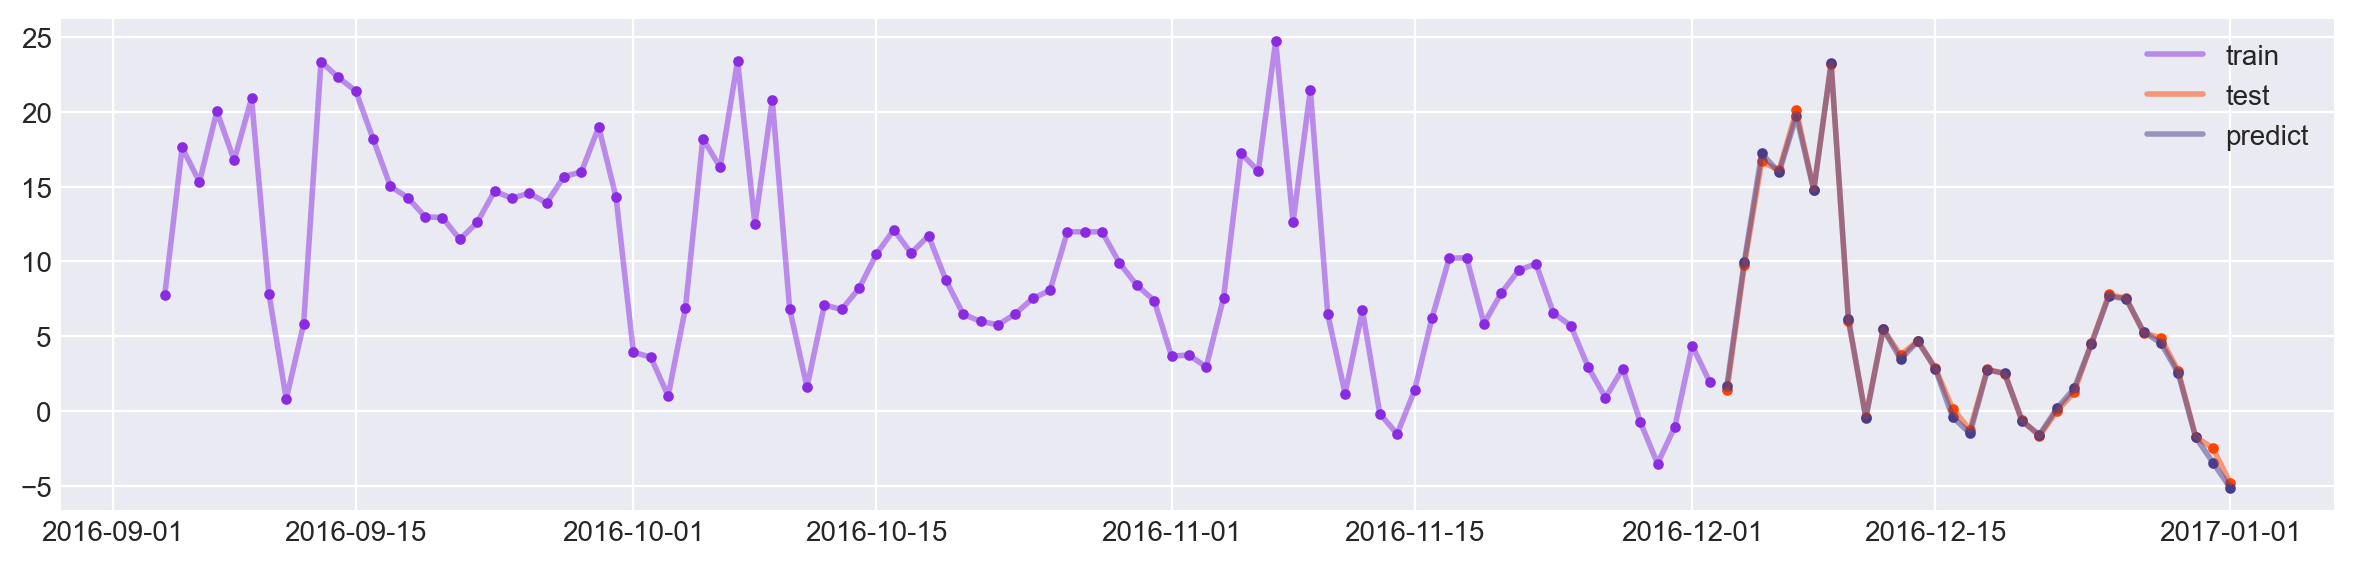

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [24]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [25]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Prep For LSTM

In [26]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 14)
dataframe shape after Feature Union (1822, 33)

data_x shape after seperate_target (1822, 32)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 32)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 32)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 32)
x_test_data  shape after Test Train Split (30, 24, 32)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/25
200/200 [==============================] - 7s 23ms/step - loss: 0.1022 - mae: 0.1952 - val_loss: 0.0051 - val_mae: 0.0593
Epoch 2/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0065 - mae: 0.0604 - val_loss: 0.0055 - val_mae: 0.0572
Epoch 3/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0029 - mae: 0.0424 - val_loss: 0.0042 - val_mae: 0.0536
Epoch 4/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0035 - mae: 0.0460 - val_loss: 0.0166 - val_mae: 0.1096
Epoch 5/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0077 - mae: 0.0682 - val_loss: 0.0133 - val_mae: 0.1021
Epoch 6/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0029 - mae: 0.0405 - val_loss: 0.0037 - val_mae: 0.0473
Epoch 7/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0018 - mae: 0.0325 - val_loss: 0.0072 - val_mae: 0.0709
Epoch 8/25
200/200 [==============================] - 4s 21ms/step - 

In [28]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

yhat_scaled shape (30, 1) (30, 1)


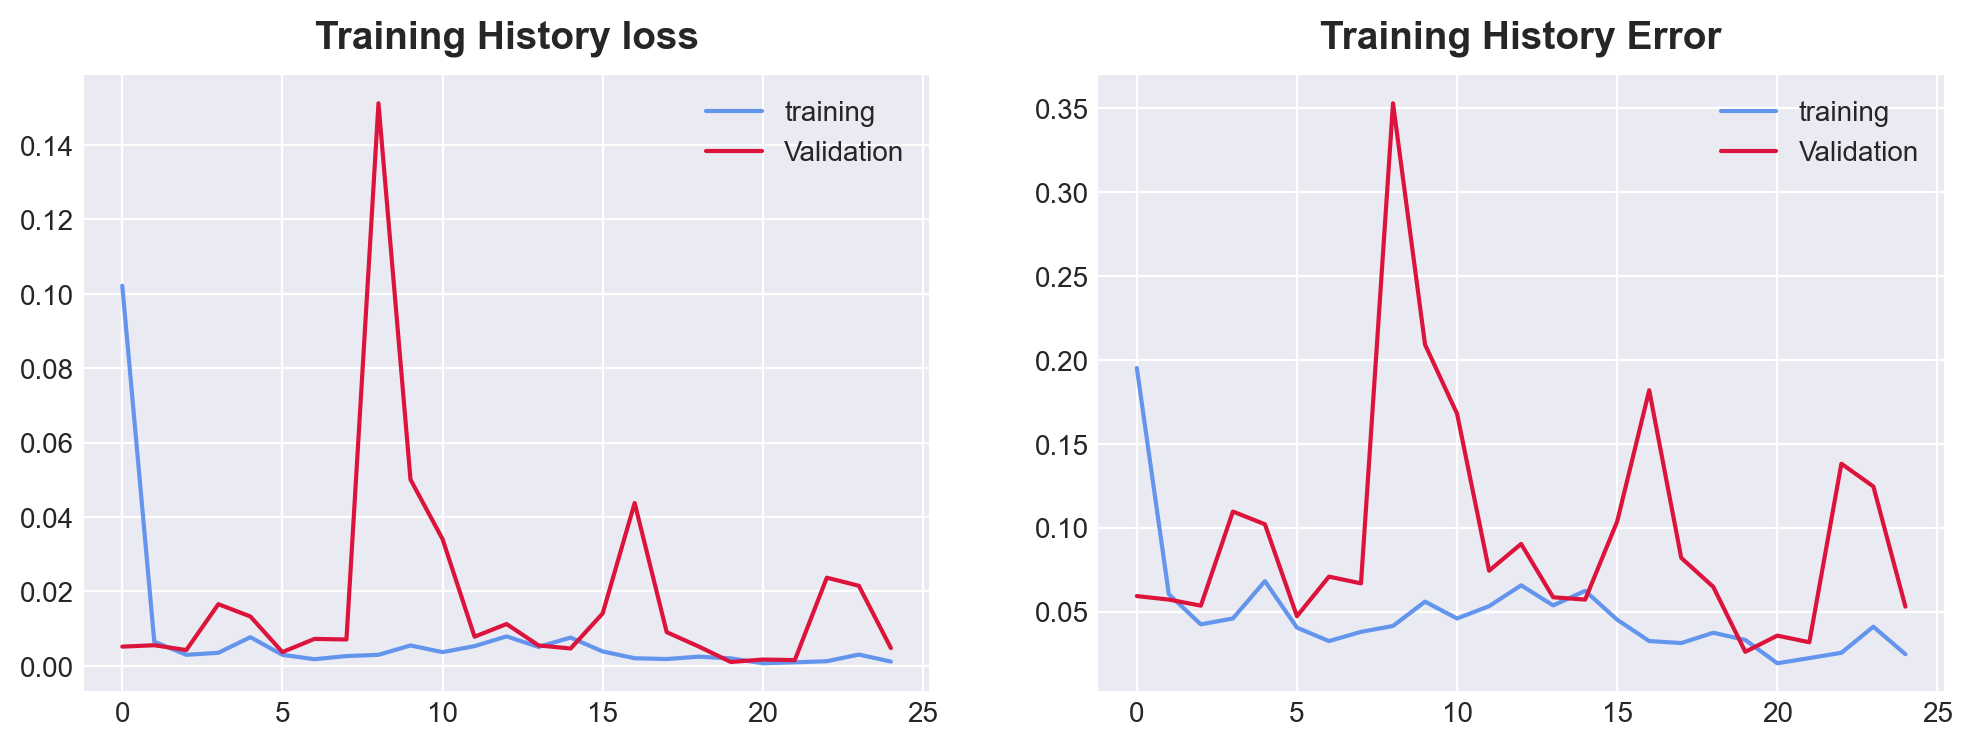

In [29]:
plot_tf_training_history(training_history)

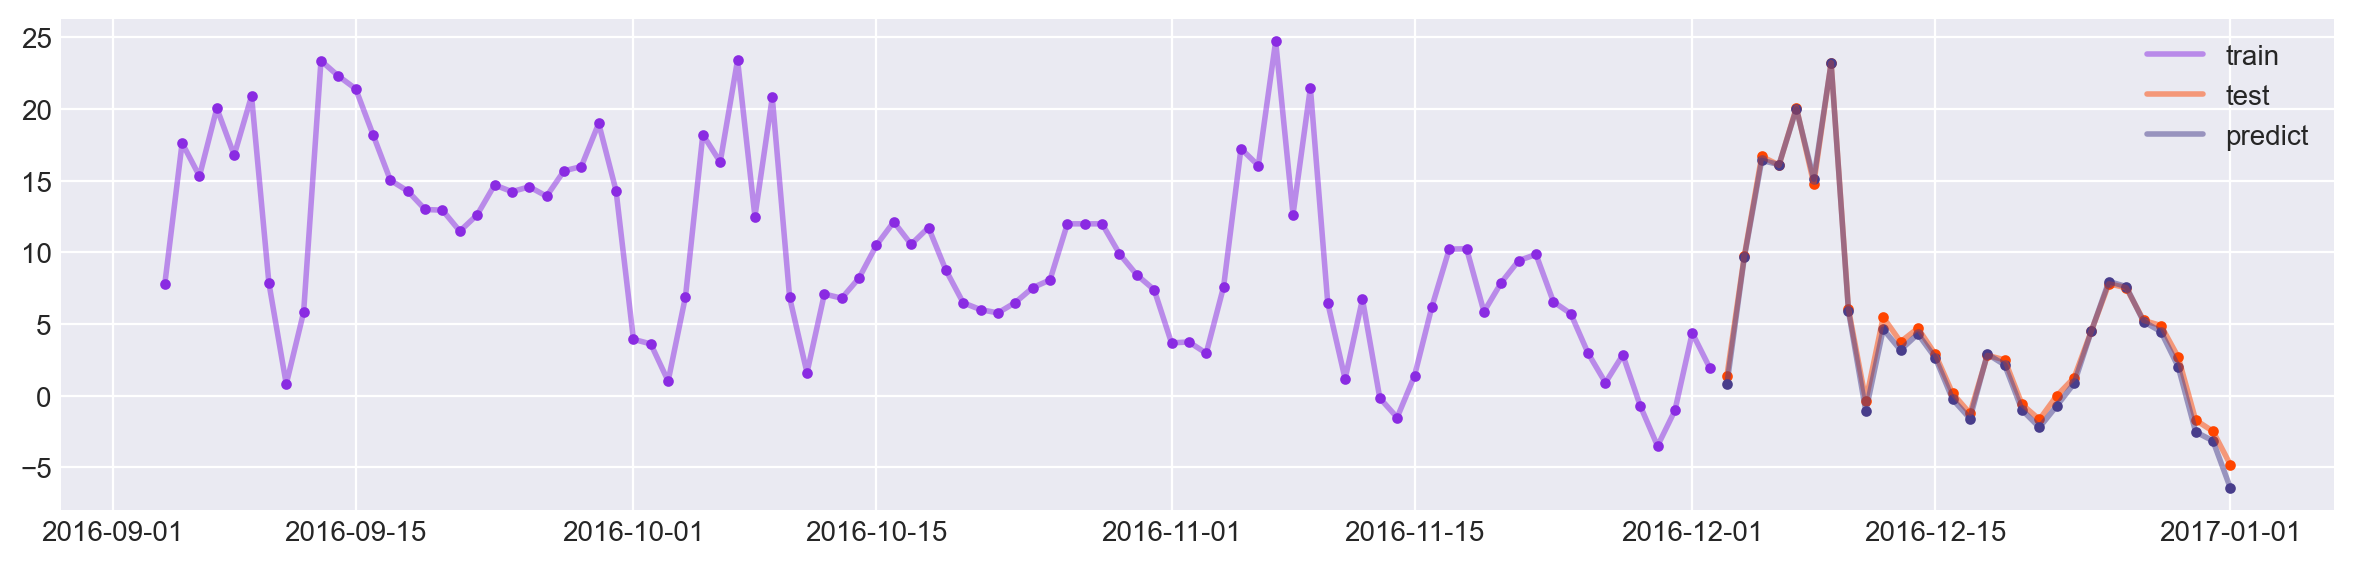

In [30]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [31]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,1.555438,0.009091,0.022241,0.125494,0.156272,0.199580,0.193672,0.402886
rmse,2.058310,0.012031,0.027784,0.146099,0.254001,0.276412,0.282922,0.524631
mape,10.192080,0.031558,0.139500,0.591462,0.280757,0.249045,1.007224,3.500494
r2,0.908727,0.999997,0.999983,0.999540,0.998610,0.998354,0.998276,0.994070


In [32]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,1.555438,2.058310,10.192080,0.908727
BayesianRidge,0.009091,0.012031,0.031558,0.999997
LassoCV,0.022241,0.027784,0.139500,0.999983
RandomForestRegressor,0.125494,0.146099,0.591462,0.999540
XGBRegressor,0.156272,0.254001,0.280757,0.998610
LGBMRegressor,0.199580,0.276412,0.249045,0.998354
CatBoostRegressor,0.193672,0.282922,1.007224,0.998276
LSTM_Dense,0.402886,0.524631,3.500494,0.994070


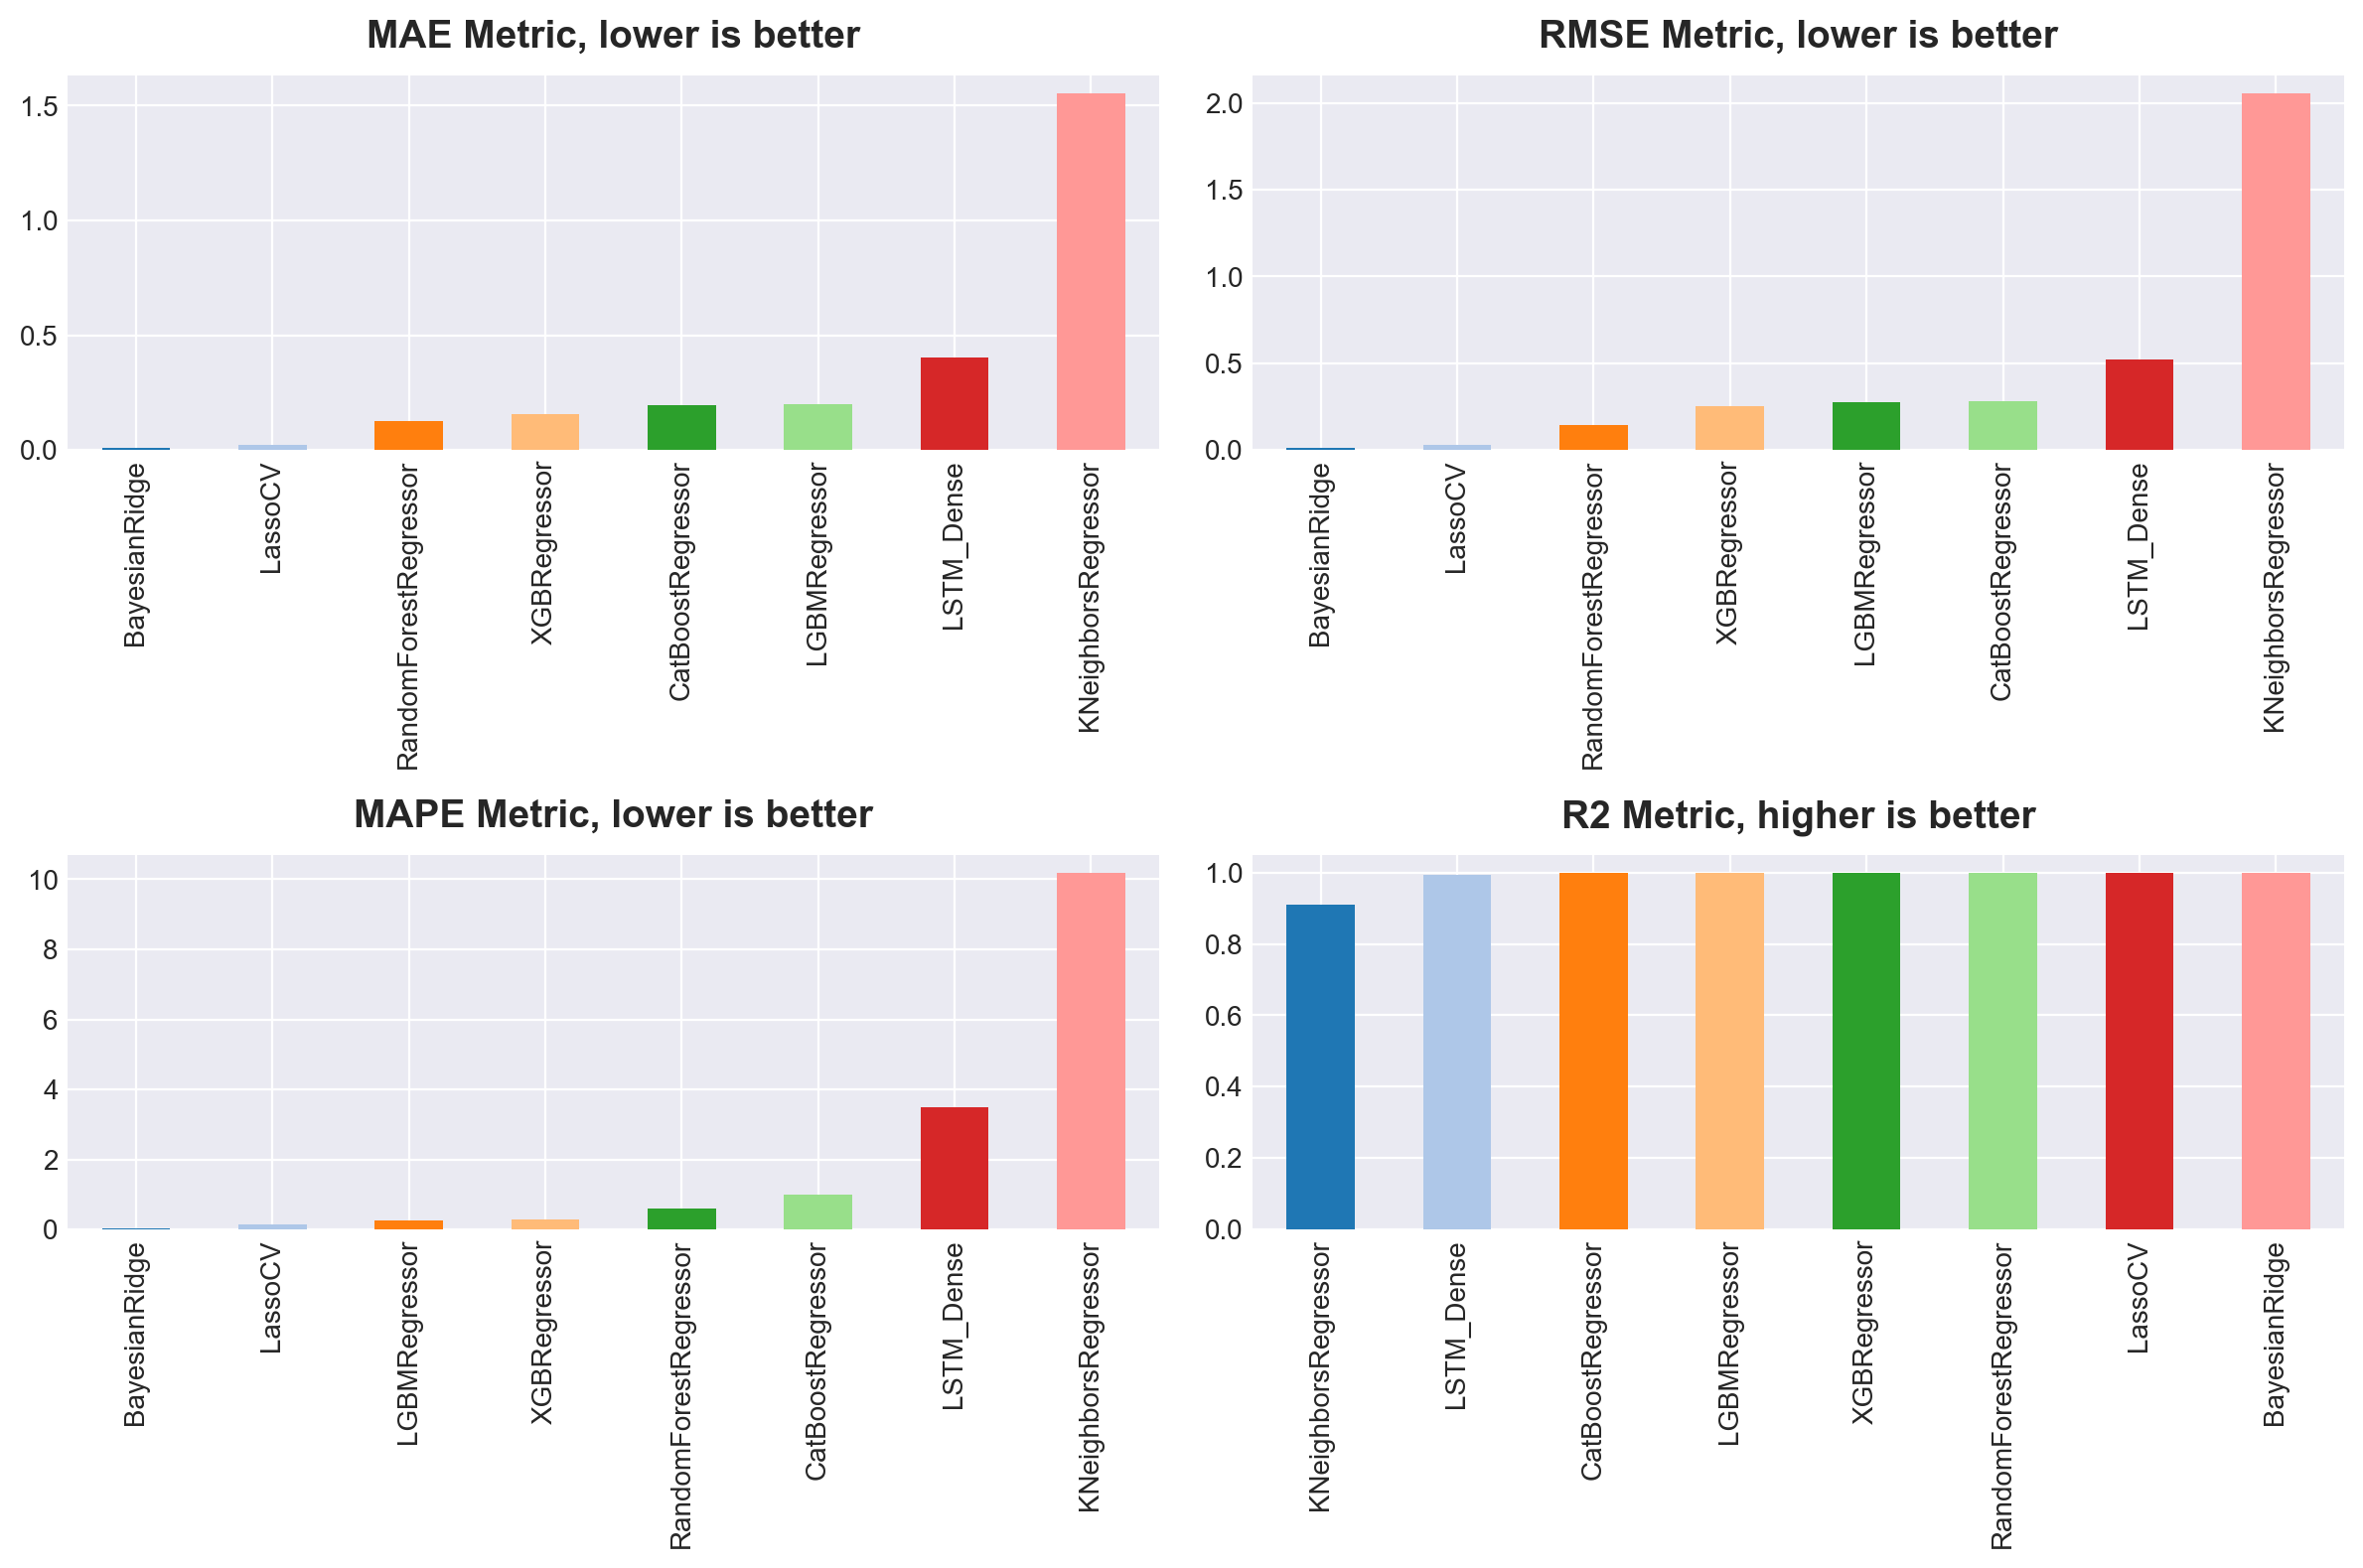

In [33]:
plot_metrics(resultsDF)

In [34]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Weather"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Weather"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Weather"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)